In [ ]:
# compare test set cluster assignment probabilities for the special sample set, IXI, and mdd only

In [502]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from numpy import matlib
import csv
from sklearn.manifold import TSNE
import matplotlib

import sys
sys.path.append('/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering')

from cv_clustering.beta_aggregate import vector_mse, aggregate, predictargmax, subfold_mse
from cv_clustering.utils import contingency_matrix, do_all_clus_corrs
from cv_clustering.loocv_assigmatcher_nov import get_co_cluster_count

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
def colorscatter(x, y, d, ax, legendyn):
    try:
        groups = set(y[~np.isnan(y)])
    except:
        groups = np.unique(y)
    colors = matplotlib.cm.tab10(np.linspace(0, 1, 10))
    ctr = -1
    for g in groups:
        ctr += 1
        findme = np.where(y == g.astype(int))[0]
        cc = np.expand_dims(colors[g.astype(int)], axis=0)
        ax.scatter(x[findme, 0], x[findme, 1], c=cc, s=d[findme] * 5)
    if legendyn==1:
        plt.legend(groups)
        
def intersect(l1, l2):
    l1=np.array(l1)
    l2=np.array(l2)
    c = []
    a = []
    b = []
    for i in l1:
        if i in l2:
            c.append(i)

            a.append(np.where(l1 == i)[0][0])
            b.append(np.where(l2 == i)[0][0])
    return c, a, b

def spit_out_vector_overlap(mddcrit,allcrit, topx, toplot):
    r,p=scipy.stats.pearsonr(mddcrit,allcrit)
    print('Pearsons correlation between the two vectors:', r,'(p=', p,')')
    if p<.05:
        if toplot==1:
            plt.plot(mddcrit); 
            plt.plot(allcrit); 
            aaa=np.nanmean([mddcrit,allcrit],axis=0)
            plt.plot(aaa); plt.show()

        a1p = np.percentile(abs(mddcrit),100-topx)
        a1=np.where(abs(mddcrit)>=a1p)[0]
        
        a2p = np.percentile(abs(allcrit),100-topx)
        a2=np.where(abs(allcrit)>=a2p)[0]

        c,a,b = intersect(a1,a2)
        print('Features that were in the top ' + str(topx) + '& of contributors in both vectors:')
        for i in range(len(c)):
            print('\t', c[i],Tclabels[c[i]],mddcrit[c[i]],allcrit[c[i]])

    
def maxvals_beta(c1):
    top10thresh = np.percentile(abs(c1),95)
    top10where=np.where(abs(c1)>top10thresh)[0]
    for i in top10where:
        print(i,Tclabels[i], c1[i])

In [2]:
# load in the control data to get data labels
Xctrlinit = pd.read_csv(r'/Users/lee_jollans/Projects/MARS_GSK_project/data/alldatacollect/controldata.csv',header=None);    
labels = np.vstack(Xctrlinit.values[0,:]).astype(str)
surf_v = np.linspace(0, 67, 68).astype(int)
thick_v = np.linspace(68, 67 + 68, 68).astype(int)
subc_v = np.append(np.linspace(137, 143, 7), np.linspace(145, 151, 7)).astype(int)
cov_v = [136, 144]
cov_s = [154, 155]
cov_t = [152, 153]
cov_c = [156, 157, 158, 159]

In [3]:
mdd_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/FEB_PUT/FEB_')
all_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/ALL/wspecsamp_')
mdd_datadir = ('/Users/lee_jollans/Projects/clustering_pilot/residfiles_all_210220/MDD__')
ixi_savedir = ('/Users/lee_jollans/Projects/clustering_pilot/IXI/IXI_')

sets = [
    "Tc",
    "Sc",
    "TSc",
    "Tc_tc",
    "Sc_sc",
    "TSc_tsc",
    "Tct_s",
    "Scs_s",
    "Tct_Scs_s",
    "Tct_tc_s",
    "Scs_sc_s",
    "Tct_Scs_tc_sc_s",
]

# load cv assignments
cv_assignment_dir = "/Users/lee_jollans/Documents/GitHub/ML_in_python/export_251019/"
with open((cv_assignment_dir + "CVassig398.csv"), "r") as f:
    reader = csv.reader(f, delimiter=",")
    mdd_cv_assignment = np.array(list(reader)).astype(float)
with open((cv_assignment_dir + "CVassig740.csv"), "r") as f:
    reader = csv.reader(f, delimiter=",")
    all_cv_assignment = np.array(list(reader)).astype(float)    
with open((cv_assignment_dir + "CVassigIXI.csv"), "r") as f:
    reader = csv.reader(f, delimiter=",")
    ixi_cv_assignment = np.array(list(reader)).astype(float)   
    
# load labels
with open((all_savedir + 'all_labelsmain_sigmoid.pkl'), "rb") as file:
    all_labelsmain2 = pickle.load(file)
with open((ixi_savedir + 'all_labelsmain_sigmoid.pkl'), "rb") as file:
    ixi_labelsmain2 = pickle.load(file)
with open((mdd_savedir + 'all_labelsmain_sigmoid.pkl'), "rb") as file:
    mdd_mdd_labelsmain2 = pickle.load(file)
with open((mdd_savedir + 'all_labelsmain_ctrl_sigmoid.pkl'), "rb") as file:
    mdd_ctrl_labelsmain2 = pickle.load(file)
    
# load probabilities
with open((all_savedir + 'all_probamain_sigmoid.pkl'), "rb") as file:
    all_probamain2 = pickle.load(file)
with open((ixi_savedir + 'all_probamain_sigmoid.pkl'), "rb") as file:
    ixi_probamain2 = pickle.load(file)
with open((mdd_savedir + 'all_probamain_sigmoid.pkl'), "rb") as file:
    mdd_mdd_probamain2 = pickle.load(file)
with open((mdd_savedir + 'all_probamain_ctrl_sigmoid.pkl'), "rb") as file:
    mdd_ctrl_probamain2 = pickle.load(file)
    
# load diagnosis labels
with open('/Users/lee_jollans/Projects/clustering_pilot/ALL/ALL_samples_idx.csv', newline='') as csvfile:
    sampleidx = list(csv.reader(csvfile))
tmpsampleidx = np.array([int(sampleidx[i][0]) for i in range(len(sampleidx))])
sampleidx = np.full([740],np.nan)
sampleidx[np.where(tmpsampleidx==1)[0]]=4
sampleidx[np.where(tmpsampleidx==2)[0]]=7
sampleidx[np.where(tmpsampleidx==3)[0]]=5
sampleidx[np.where(tmpsampleidx==4)[0]]=6
sampleidx[np.where(tmpsampleidx==5)[0]]=1
sampleidx[np.where(tmpsampleidx==6)[0]]=2
sampleidx[np.where(tmpsampleidx==7)[0]]=3

mddinall = np.where(sampleidx==2)
dummy_mdd = np.zeros(740);
dummy_mdd[mddinall]=np.ones(398)

In [4]:
# extract testprobabilities for mainfold test sets
all_testproba = np.full([8,12,4],np.nan)
ixi_testproba = np.full([8,12,4],np.nan)
mdd_testproba_mddresid = np.full([8,12,4],np.nan)
mdd_testproba_ctrlresid = np.full([8,12,4],np.nan)

for s in range(len(sets)):
    for mf in range(4):
        maintest_all = np.where(np.isnan(all_cv_assignment[:,mf]))[0]
        maintest_ixi = np.where(np.isnan(ixi_cv_assignment[:,mf]))[0]
        maintest_mdd = np.where(np.isnan(mdd_cv_assignment[:,mf]))[0]
        
        for k in range(8):            
            all_test = all_probamain2[maintest_all,s,k,mf]
            ixi_test = ixi_probamain2[maintest_ixi,s,k,mf]
            mdd_mdd_test = mdd_mdd_probamain2[maintest_mdd,s,k,mf]
            mdd_ctrl_test = mdd_ctrl_probamain2[maintest_mdd,s,k,mf]
            
            all_testproba[k,s,mf]=np.nanmean(all_test)
            ixi_testproba[k,s,mf]=np.nanmean(ixi_test)
            mdd_testproba_mddresid[k,s,mf]=np.nanmean(mdd_mdd_test)
            mdd_testproba_ctrlresid[k,s,mf]=np.nanmean(mdd_ctrl_test)

In [5]:
modality = [0,1,2]*4
datatype = [0,0,0,1,1,1,2,2,2,3,3,3]

df = pd.DataFrame({}, columns=['set','mod','res_cov','data','CV', 'k','testproba'])

for s in range(len(sets)):
    for k in range(8):
        for mf in range(4):
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'all','CV':mf,'k':k+2,'testproba': [all_testproba[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
            
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'ixi','CV':mf,'k':k+2,'testproba': [ixi_testproba[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
            
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'mdd_mddresid','CV':mf,'k':k+2,'testproba': [mdd_testproba_mddresid[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
            
            tmp_df = pd.DataFrame({'set':sets[s],'mod':modality[s],'res_cov':datatype[s],
                                   'data':'mdd_ctrlresid','CV':mf,'k':k+2,'testproba': [mdd_testproba_ctrlresid[k,s,mf]]},
                columns=['set','mod','res_cov','data','CV', 'k','testproba'])
            df = df.append(tmp_df)
               

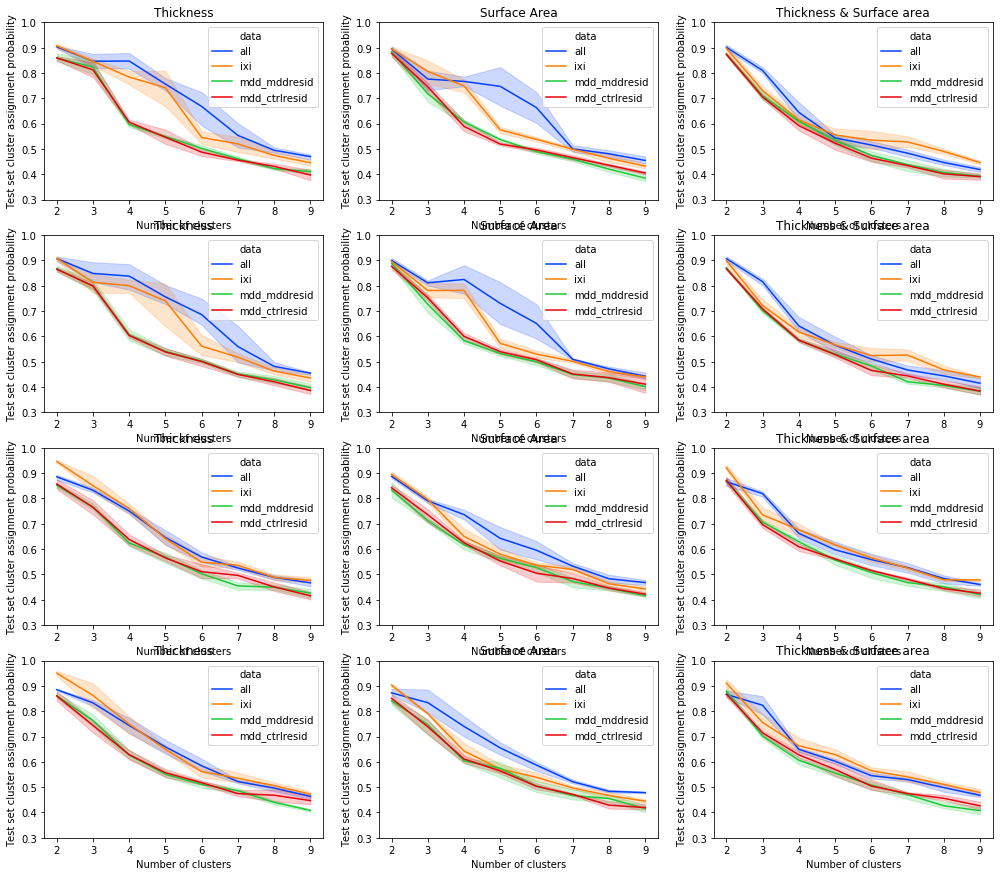

In [6]:
fig = plt.figure(figsize=[17,15])
modlabel=['Thickness','Surface Area','Thickness & Surface area']
ctr=0
for d in range(4):
    df2=df[df['res_cov']==d]
    for mod in range(3):
        ctr+=1
        plt.subplot(4,3,ctr)
        df3=df2[df2['mod']==mod]
        sns.lineplot(y='testproba',x='k',hue='data',data=df3, palette='bright')
        plt.ylim([0.3,1])
        plt.xlabel('Number of clusters')
        plt.ylabel('Test set cluster assignment probability')
        plt.title(modlabel[mod])
plt.show()

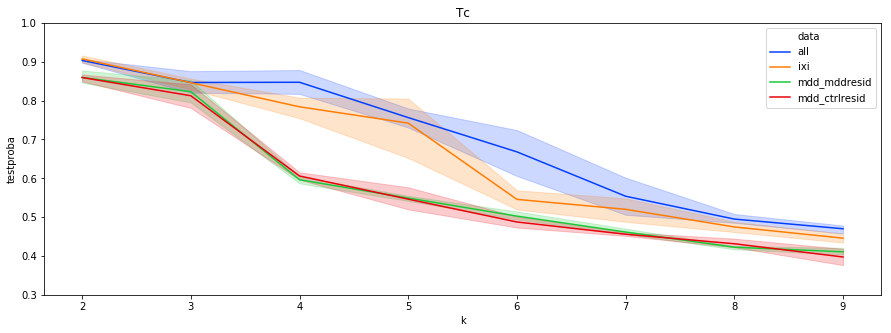

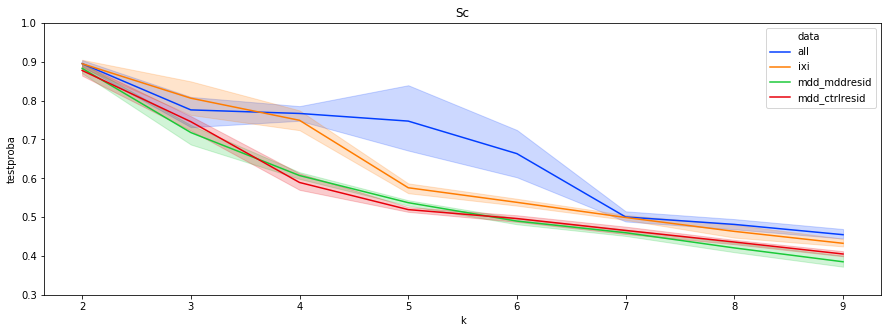

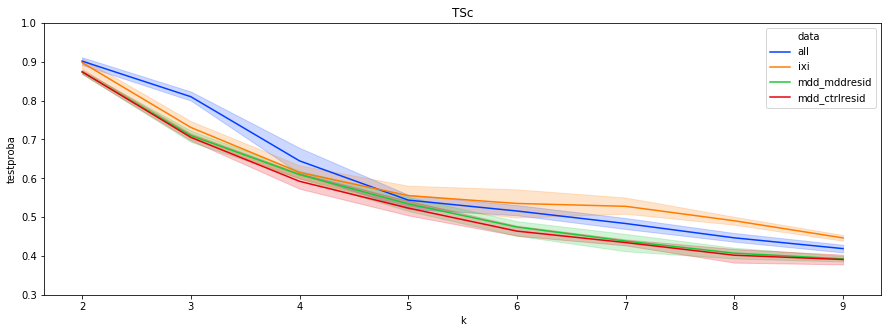

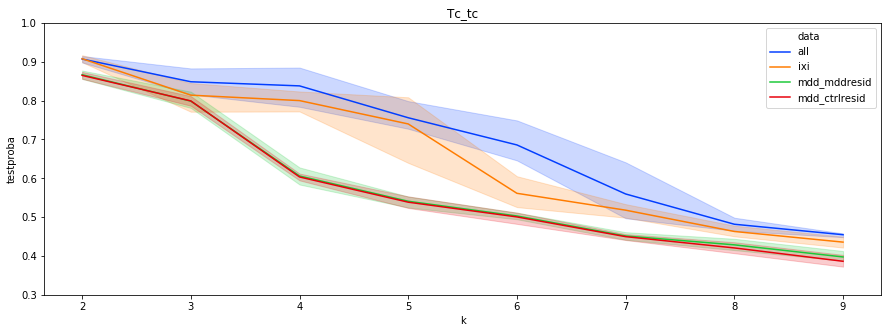

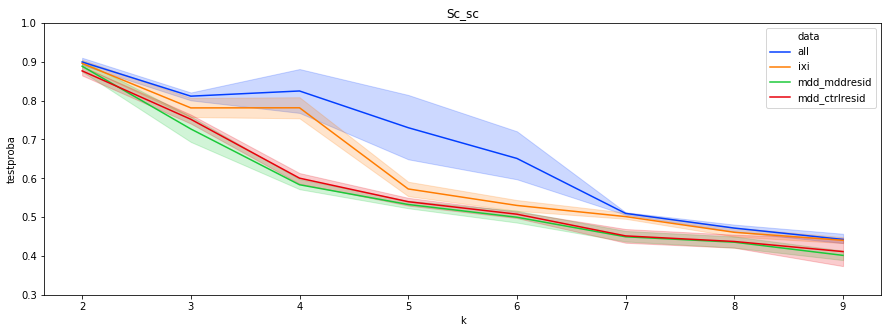

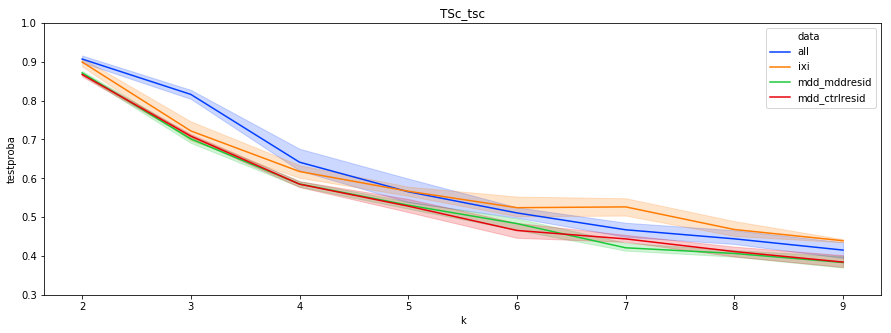

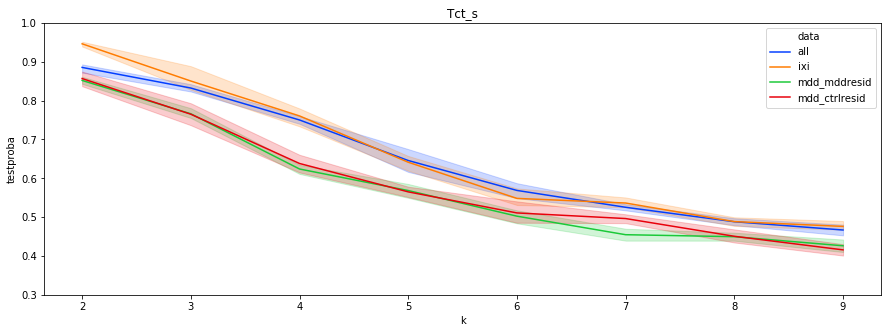

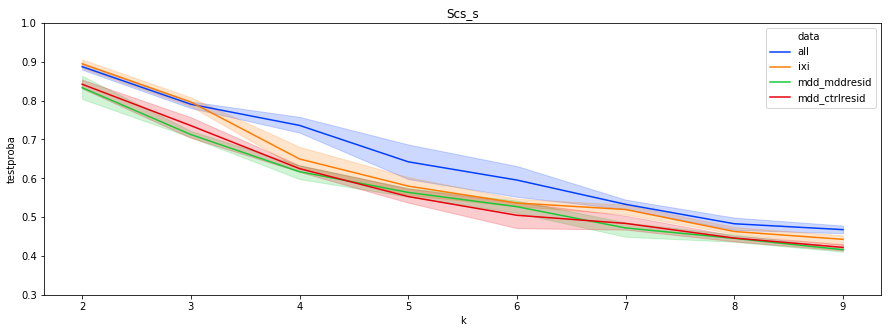

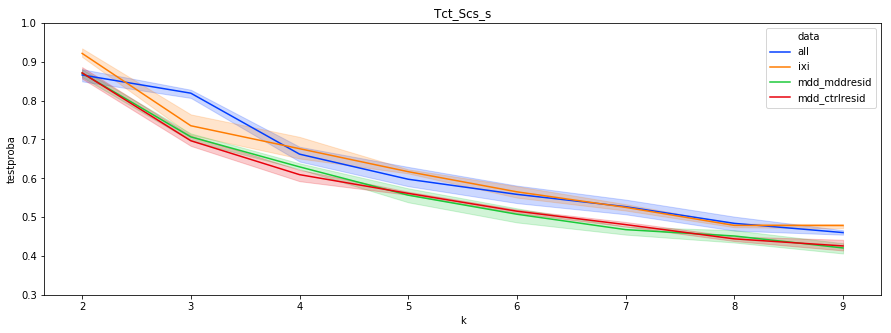

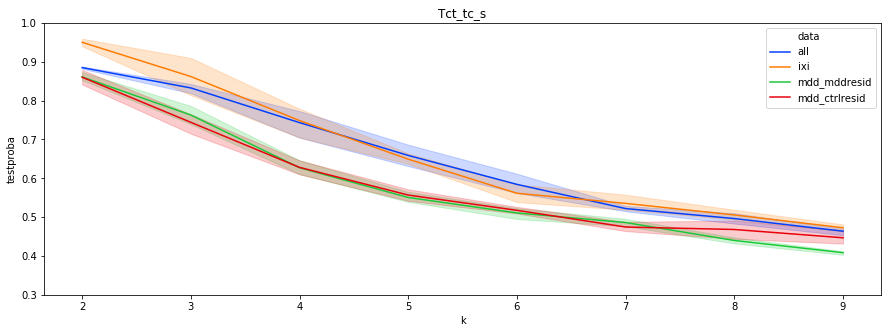

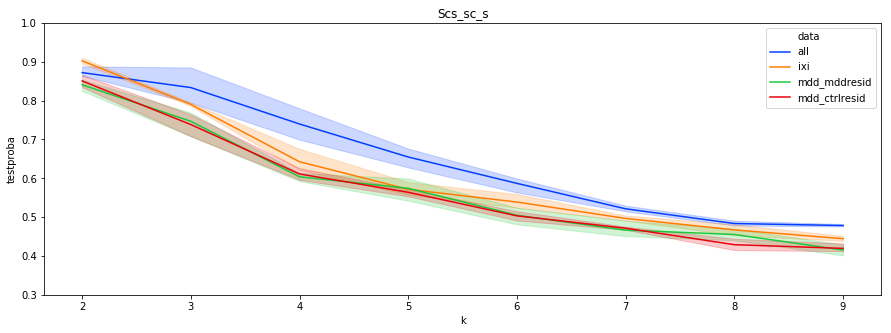

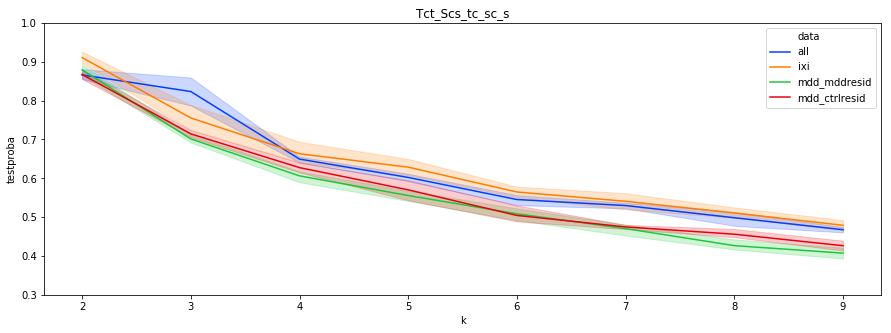

In [7]:
for s in range(len(sets)):
    fig = plt.figure(figsize=[15,5])
    df2=df[df['set']==sets[s]]
    sns.lineplot(y='testproba',x='k',hue='data',data=df2, palette='bright')
    plt.ylim([0.3,1])
    plt.title(sets[s])
plt.show()

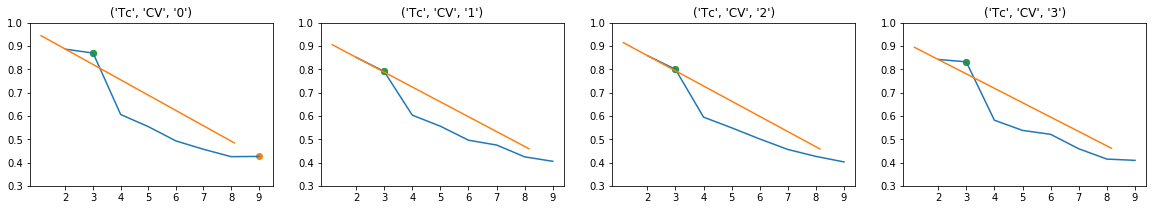

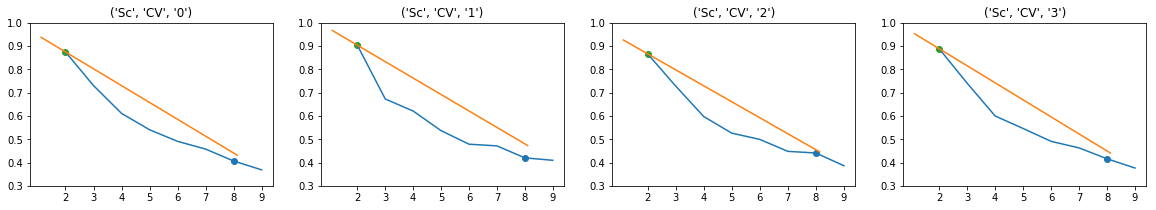

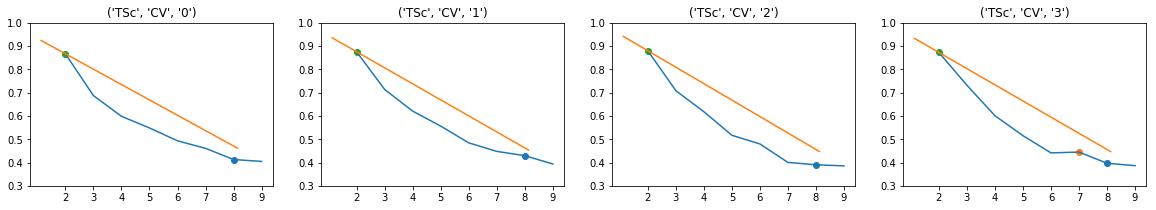

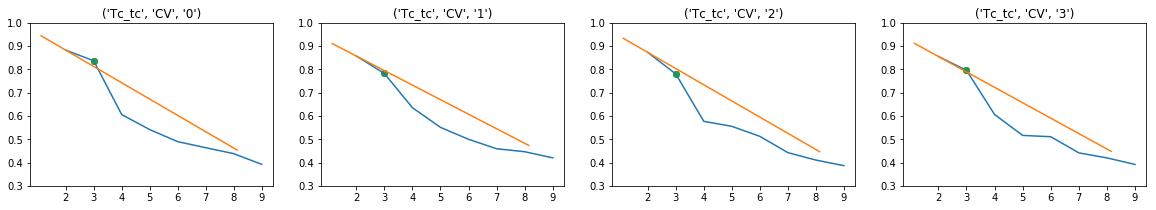

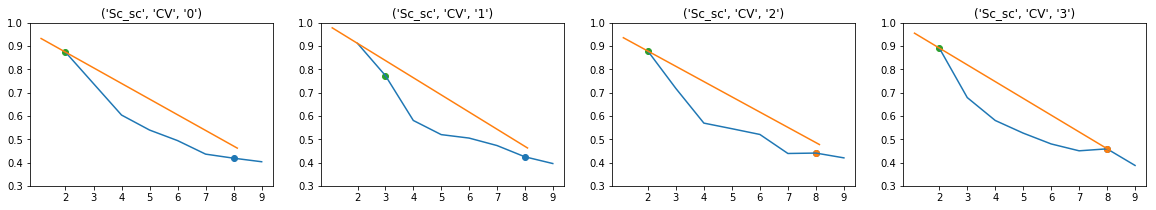

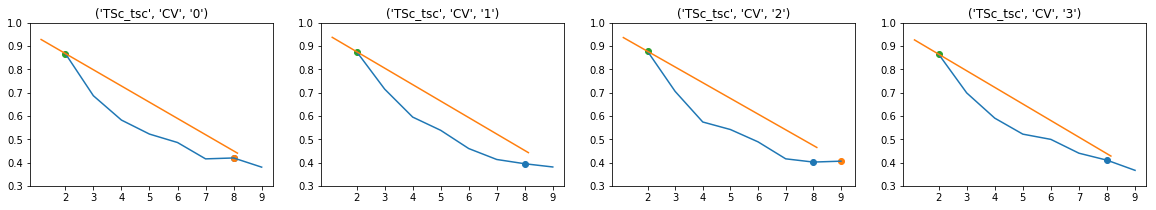

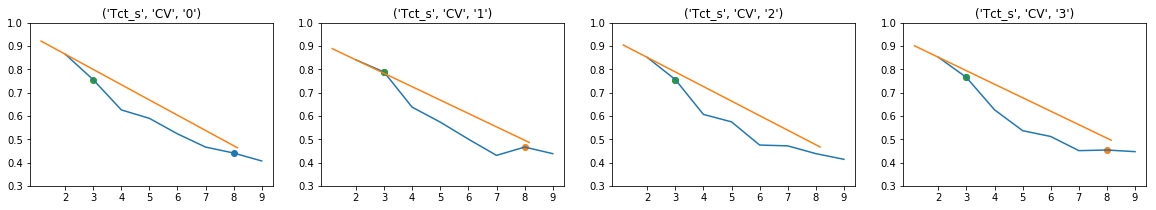

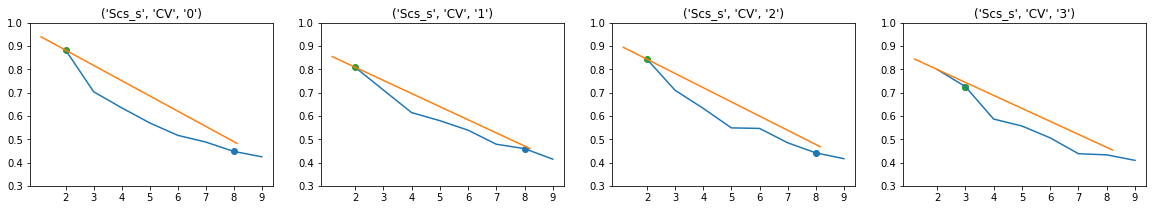

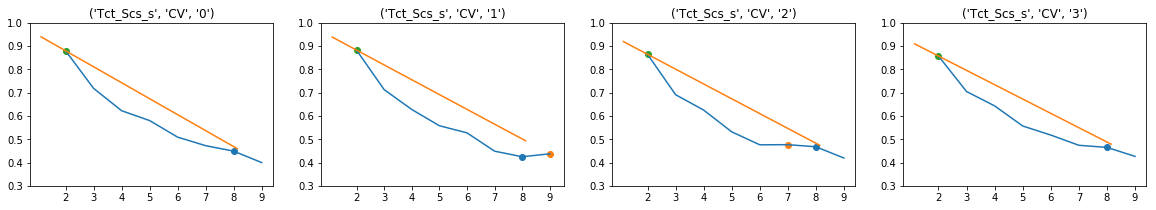

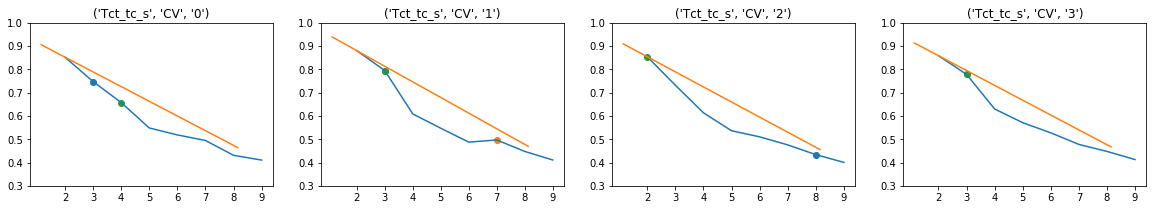

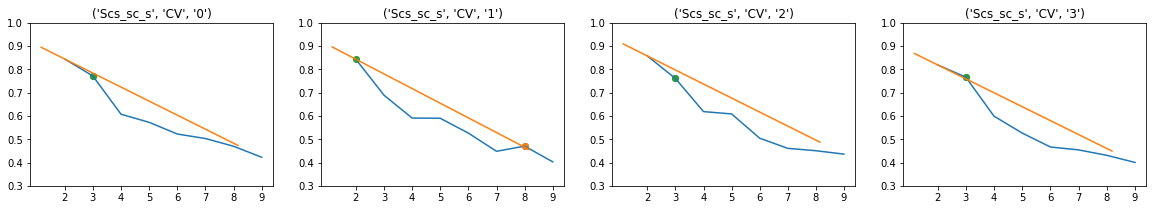

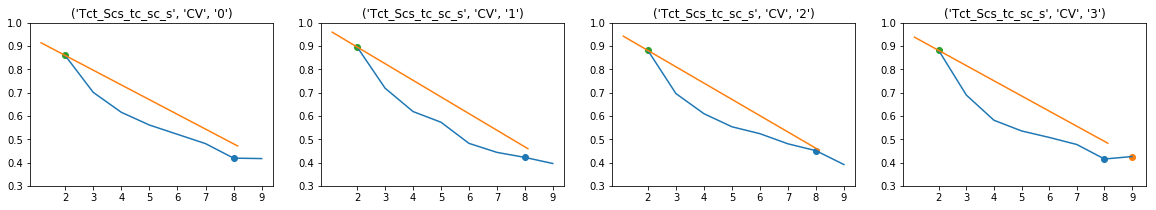

In [8]:
# now go through every mainfold and select optimal point in the testproba curve
k_to_use_mdd_mddresid_mindist = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid_increase = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid_decrease = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid_incodec = np.full([len(sets),4],np.nan)
for s in range(len(sets)):
    fig = plt.figure(figsize=[20,3])
    for mf in range(4):
        plt.subplot(1,4,mf+1)
        curve = mdd_testproba_mddresid[:,s,mf]
        plt.plot(curve)
        
        # get line from first to last point to get elbow/knee
        allCoord = np.vstack((np.arange(len(curve)), curve)).T
        lineVec = allCoord[-1] - allCoord[0]
        lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
        vecFromFirst = allCoord - curve[0]
        scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, len(curve), 1), axis=1)
        vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
        vecToLine = vecFromFirst - vecFromFirstParallel
        plt.plot(vecFromFirstParallel[:,0],vecFromFirstParallel[:,1]+curve[0])
        
        # distance from parallel
        distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
        a = distToLine[1:-1]
        i = np.where(a==np.min(a))[0]+1
        k_to_use_mdd_mddresid_mindist[s,mf]=i
        plt.scatter(i,curve[i])
        
        increases_before = (curve[1:]-curve[:-1])
        k_to_use_mdd_mddresid_increase[s,mf]=np.where(increases_before==np.max(increases_before))[0]+1
        increases = np.where(increases_before>0)[0]+1
        plt.scatter(increases,curve[increases])
        
        decreases_after = (curve[:-1]-curve[1:])
        k_to_use_mdd_mddresid_decrease[s,mf]=np.where(decreases_after==np.max(decreases_after))[0]
        max_decrease_after = np.where(decreases_after == np.max(decreases_after))[0]
        plt.scatter(max_decrease_after,curve[max_decrease_after])

        decrease_over_increase = decreases_after[1:]/abs(increases_before[:-1])
        k_to_use_mdd_mddresid_incodec[s,mf]=np.where(decrease_over_increase==np.max(decrease_over_increase))[0]+3
        
        plt.ylim([0.3,1])
        plt.title((sets[s], 'CV',str(mf)))
        plt.xticks(np.arange(8),np.arange(8)+2)
    plt.show()

In [9]:
for s in range(len(sets)):
    print(k_to_use_mdd_mddresid_mindist[s,:]+2,k_to_use_mdd_mddresid_increase[s,:]+2,k_to_use_mdd_mddresid_decrease[s,:]+2,k_to_use_mdd_mddresid_incodec[s,:],sets[s])

[3. 3. 3. 3.] [9. 9. 9. 9.] [3. 3. 3. 3.] [3. 3. 3. 3.] Tc
[8. 8. 8. 8.] [7. 7. 8. 7.] [2. 2. 2. 2.] [7. 7. 8. 7.] Sc
[8. 8. 8. 8.] [9. 8. 9. 7.] [2. 2. 2. 2.] [7. 8. 6. 7.] TSc
[3. 3. 3. 3.] [8. 8. 5. 6.] [3. 3. 3. 3.] [3. 8. 3. 6.] Tc_tc
[8. 8. 8. 8.] [9. 6. 8. 8.] [2. 3. 2. 2.] [6. 6. 8. 8.] Sc_sc
[8. 8. 8. 8.] [8. 9. 9. 6.] [2. 2. 2. 2.] [8. 5. 5. 6.] TSc_tsc
[8. 3. 3. 3.] [8. 8. 7. 8.] [3. 3. 3. 3.] [5. 3. 7. 8.] Tct_s
[8. 8. 8. 3.] [9. 8. 6. 8.] [2. 2. 2. 3.] [7. 8. 6. 8.] Scs_s
[8. 8. 8. 8.] [8. 9. 7. 8.] [2. 2. 2. 2.] [8. 6. 7. 8.] Tct_Scs_s
[3. 3. 8. 3.] [9. 7. 6. 8.] [4. 3. 2. 3.] [7. 7. 6. 3.] Tct_tc_s
[3. 8. 3. 3.] [7. 8. 5. 7.] [3. 2. 3. 3.] [3. 5. 5. 3.] Scs_sc_s
[8. 8. 8. 8.] [9. 8. 8. 9.] [2. 2. 2. 2.] [7. 5. 8. 7.] Tct_Scs_tc_sc_s


In [10]:
k_to_use_mdd_mddresid = np.full([len(sets),4],np.nan)
k_to_use_mdd_mddresid[0,:]=[3,3,3,3] #t
k_to_use_mdd_mddresid[1,:]=[7,7,8,7] #s
k_to_use_mdd_mddresid[2,:]=[7,8,6,7] #ts
k_to_use_mdd_mddresid[3,:]=[3,3,3,3] #t ##
k_to_use_mdd_mddresid[4,:]=[6,7,6,8] #s
k_to_use_mdd_mddresid[5,:]=[6,5,5,6] #ts
k_to_use_mdd_mddresid[6,:]=[5,3,3,3] #t ##
k_to_use_mdd_mddresid[7,:]=[7,6,6,6] #s
k_to_use_mdd_mddresid[8,:]=[5,6,8,8] #ts
k_to_use_mdd_mddresid[9,:]=[7,7,7,8] #t ##
k_to_use_mdd_mddresid[10,:]=[3,5,5,3] #s
k_to_use_mdd_mddresid[11,:]=[7,5,8,7] #ts

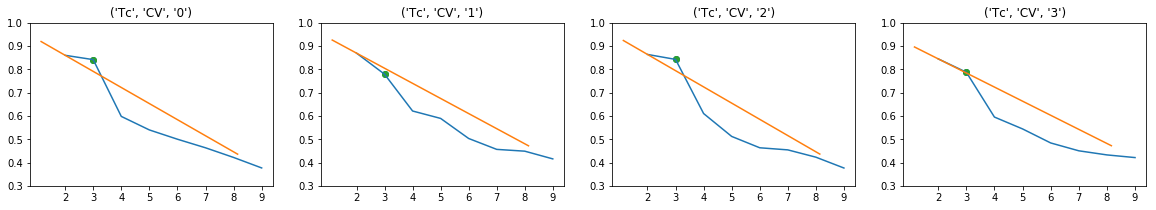

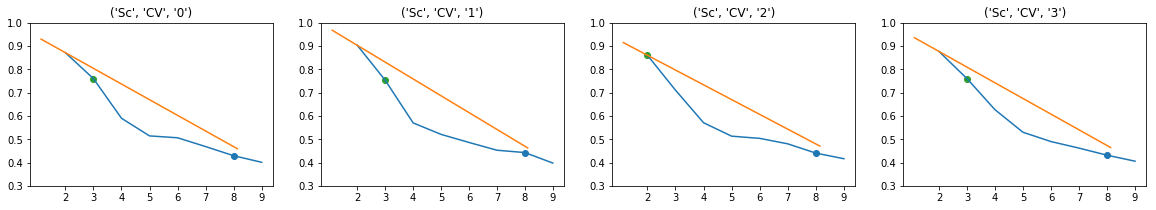

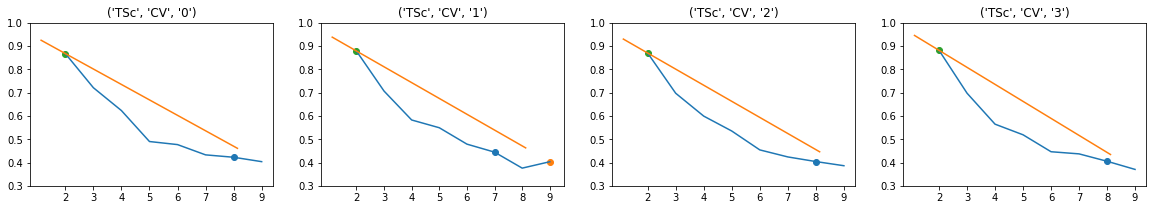

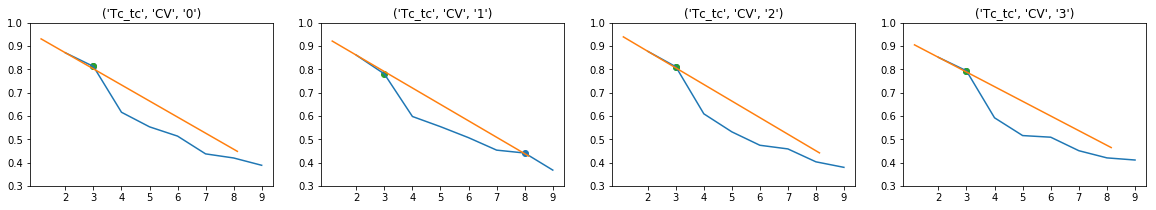

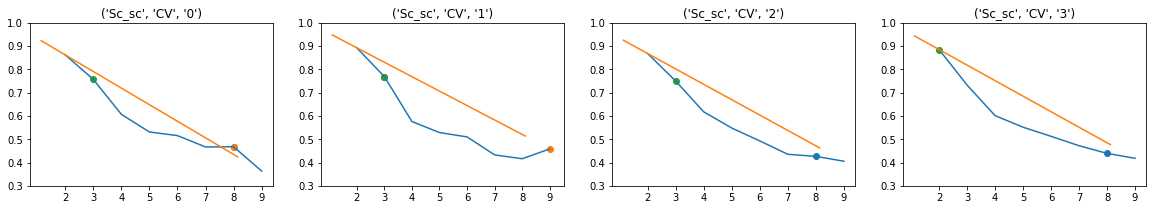

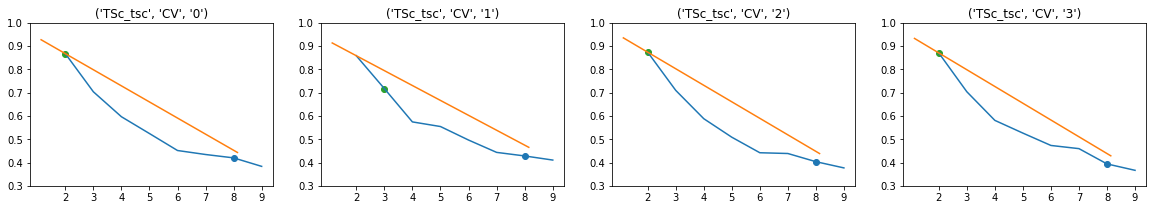

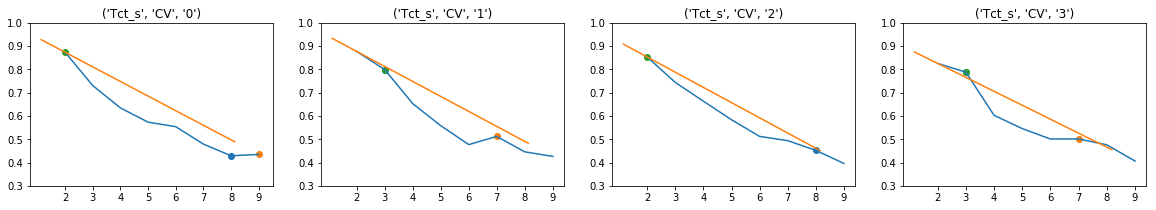

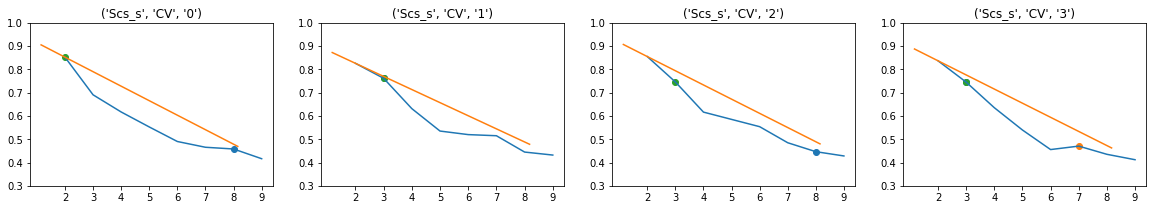

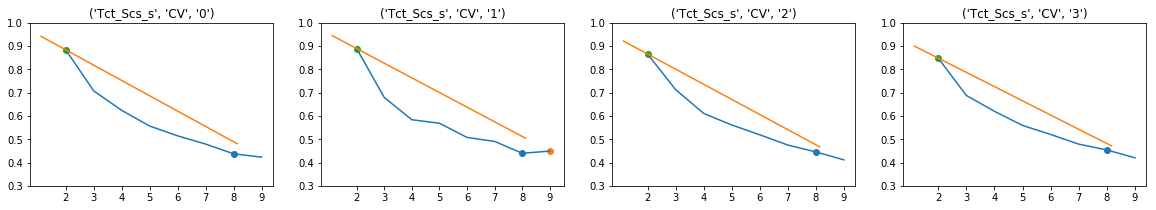

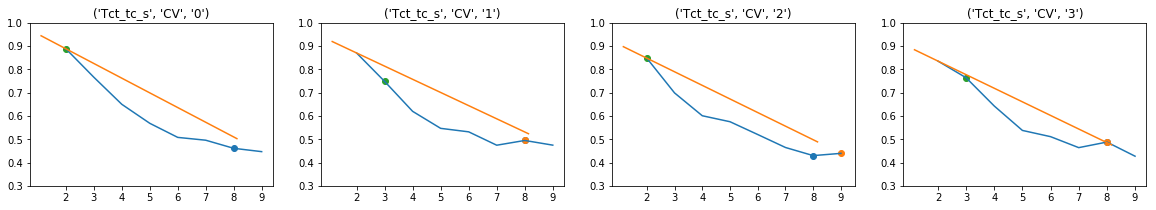

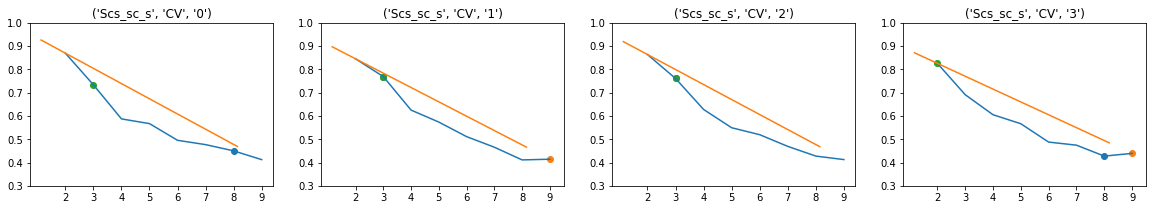

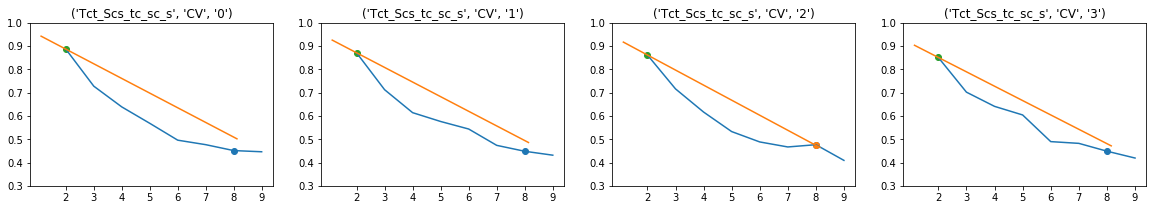

In [65]:
# same thing but plotting control corrected data
for s in range(len(sets)):
    fig = plt.figure(figsize=[20,3])
    for mf in range(4):
        plt.subplot(1,4,mf+1)
        curve = mdd_testproba_ctrlresid[:,s,mf]
        plt.plot(curve)
        
        # get line from first to last point to get elbow/knee
        allCoord = np.vstack((np.arange(len(curve)), curve)).T
        lineVec = allCoord[-1] - allCoord[0]
        lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
        vecFromFirst = allCoord - curve[0]
        scalarProduct = np.sum(vecFromFirst * np.matlib.repmat(lineVecNorm, len(curve), 1), axis=1)
        vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
        vecToLine = vecFromFirst - vecFromFirstParallel
        plt.plot(vecFromFirstParallel[:,0],vecFromFirstParallel[:,1]+curve[0])
        
        # distance from parallel
        distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
        a = distToLine[1:-1]
        i = np.where(a==np.min(a))[0]+1
        plt.scatter(i,curve[i])
        
        increases_before = (curve[1:]-curve[:-1])
        increases = np.where(increases_before>0)[0]+1
        plt.scatter(increases,curve[increases])
        
        decreases_after = (curve[:-1]-curve[1:])
        max_decrease_after = np.where(decreases_after == np.max(decreases_after))[0]
        plt.scatter(max_decrease_after,curve[max_decrease_after])

        decrease_over_increase = decreases_after[1:]/abs(increases_before[:-1])
        
        plt.ylim([0.3,1])
        plt.title((sets[s], 'CV',str(mf)))
        plt.xticks(np.arange(8),np.arange(8)+2)
    plt.show()

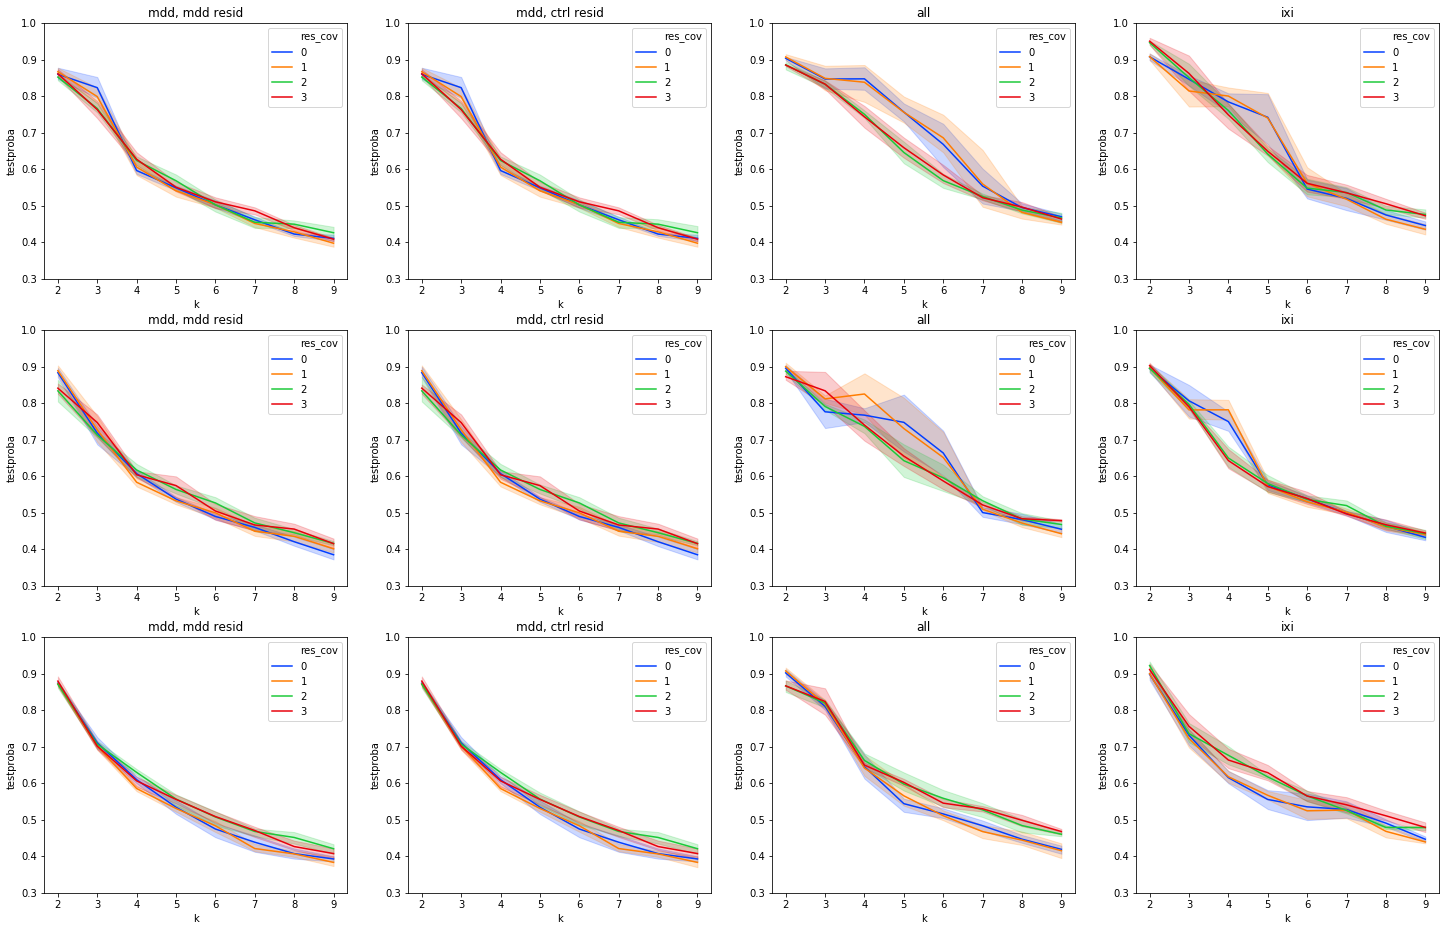

In [12]:
# plot all thickness lines
fig=plt.figure(figsize=[25,16])
a=[0,3,6,9]
ctr=0
for mod in range(3):
    plt.subplot(3,4,(mod*4)+1); plt.title('mdd, mdd resid'); plt.ylim([0.3,1])
    df2=df[(df['mod']==mod) & (df['data']=='mdd_mddresid')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')

    plt.subplot(3,4,(mod*4)+2); plt.title('mdd, ctrl resid'); plt.ylim([0.3,1])
    pdf2=df[(df['mod']==mod) & (df['data']=='mdd_ctrlresid')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')

    plt.subplot(3,4,(mod*4)+3); plt.title('all'); plt.ylim([0.3,1])
    df2=df[(df['mod']==mod) & (df['data']=='all')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')
    
    plt.subplot(3,4,(mod*4)+4); plt.title('ixi'); plt.ylim([0.3,1])
    df2=df[(df['mod']==mod) & (df['data']=='ixi')]
    sns.lineplot(y='testproba',x='k',hue='res_cov',data=df2, palette='bright')
        
plt.show()

In [13]:
# let's look at the solutions for thickness
print('three cluster solutions for thickness')
print('mdd resid mdd:',np.mean(mdd_testproba_mddresid[1,[0,3,6,9],:],axis=1))
print('mdd resid ctrl:',np.mean(mdd_testproba_ctrlresid[1,[0,3,6,9],:],axis=1))
print('four cluster solutions for thickness')
print('all resid ctrl:',np.mean(all_testproba[2,[0,3,6,9],:],axis=1))
print('five cluster solutions for thickness')
print('ixi resid ctrl:',np.mean(ixi_testproba[3,[0,3,6,9],:],axis=1))

three cluster solutions for thickness
mdd resid mdd: [0.82316777 0.79878108 0.76617138 0.76302812]
mdd resid ctrl: [0.812684   0.79932349 0.76505044 0.7442481 ]
four cluster solutions for thickness
all resid ctrl: [0.84735245 0.8380441  0.75025474 0.74342572]
five cluster solutions for thickness
ixi resid ctrl: [0.74210227 0.74001703 0.64144306 0.64930062]


In [14]:
# load aggregated beta weigths per CV fold
mdd_mdd_betas = np.full([83,3,4],np.nan)
mdd_ctrl_betas = np.full([83,3,4],np.nan)
all_betas = np.full([83,4,4],np.nan)
ixi_betas = np.full([83,5,4],np.nan)

ALLBETAS = []
MDDMDDBETAS = []
IXIBETAS = []
MDDCTRLBETAS = []
for mf in range(4):
    with open((mdd_savedir + 'Tc_aggregated_betas_k1_' + str(mf) + '.csv'), "r") as f:
        mdd_mdd_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    with open((mdd_savedir + 'Tc_aggregated_betas_k1_ctrl_' + str(mf) + '.csv'), "r") as f:
        mdd_ctrl_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    with open((all_savedir + 'Tc_aggregated_betas_k2_' + str(mf) + '.csv'), "r") as f:
        all_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    with open((ixi_savedir + 'Tc_aggregated_betas_k3_' + str(mf) + '.csv'), "r") as f:
        ixi_betas[:,:,mf] = np.array(list(csv.reader(f, delimiter=","))).astype(float)
    ALLBETAS.append(all_betas[:,:,mf])
    MDDMDDBETAS.append(mdd_mdd_betas[:,:,mf])
    IXIBETAS.append(ixi_betas[:,:,mf])
    MDDCTRLBETAS.append(mdd_ctrl_betas[:,:,mf])

# load data
with open((mdd_datadir + 'Tc.csv'), "r") as f:
    mdd_mdd_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open((mdd_datadir + 'Tc_ctrl.csv'), "r") as f:
    mdd_ctrl_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open((all_savedir + 'Tc_ctrl.csv'), "r") as f:
    all_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)
with open((ixi_savedir + 'Tc.csv'), "r") as f:
    ixi_Tc = np.array(list(csv.reader(f, delimiter=","))).astype(float)

Tclabels = labels[np.concatenate([thick_v, subc_v])]

In [19]:
ALLallmses, r, r, r, r, r = subfold_mse(ALLBETAS)
IXIallmses, r, r, r, r, r = subfold_mse(IXIBETAS)
MDDMDDallmses, r, r, r, r, r = subfold_mse(MDDMDDBETAS)
MDDCTRLallmses, r, r, r, r, r = subfold_mse(MDDCTRLBETAS)
ALLallcorrs = do_all_clus_corrs(ALLBETAS,1)
IXIallcorrs = do_all_clus_corrs(IXIBETAS,1)
MDDMDDallcorrs = do_all_clus_corrs(MDDMDDBETAS,1)
MDDCTRLallcorrs = do_all_clus_corrs(MDDCTRLBETAS,1)

/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering/beta_aggregate.py:32: RuntimeWarning: Mean of empty slice
  [allmses[sf1, sf2, z[0][i], z[1][i]] for i in range(len(z[0]))])
/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering/beta_aggregate.py:32: RuntimeWarning: Mean of empty slice
  [allmses[sf1, sf2, z[0][i], z[1][i]] for i in range(len(z[0]))])
/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering/beta_aggregate.py:32: RuntimeWarning: Mean of empty slice
  [allmses[sf1, sf2, z[0][i], z[1][i]] for i in range(len(z[0]))])
/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering/beta_aggregate.py:40: RuntimeWarning: Mean of empty slice
  [allmses[sf1, sf2, mfit[0][i], mfit[1][i]] for i in range(len(mfit[0]))])
/Users/lee_jollans/PycharmProjects/mdd_clustering/cv_clustering/beta_aggregate.py:32: RuntimeWarning: Mean of empty slice
  [allmses[sf1, sf2, z[0][i], z[1][i]] for i in range(len(z[0]))])
/Users/lee_jollans/PycharmProjects/mdd_cluster

In [359]:
def check_clus_correspondence(IXIallcorrs,IXIallmses, thresh,alllabels):
    allcr = IXIallcorrs.flatten(); allcr=np.delete(allcr,np.where(np.isnan(allcr))[0])
    allc = IXIallmses.flatten(); allc=np.delete(allc,np.where(np.isnan(allc))[0])
    all_high_r=np.where(IXIallmses<np.percentile(allc,thresh))
    assignedwhere = np.zeros(shape=[IXIallcorrs.shape[0], IXIallcorrs.shape[2]])
    cluscounter=0
    for n in range(len(all_high_r[0])):
        mf1=all_high_r[0][n]; c1=all_high_r[2][n]
        mf2=all_high_r[1][n]; c2=all_high_r[3][n]
        if IXIallcorrs[mf1,mf2,c1,c2]>np.percentile(allc,thresh):
            if assignedwhere[mf1,c1]==0 and assignedwhere[mf2,c2]==0:
                cluscounter+=1
                assignedwhere[mf1,c1]=cluscounter
                assignedwhere[mf2,c2]=cluscounter
            elif assignedwhere[mf1,c1]!=0 and assignedwhere[mf2,c2]!=0:
                if assignedwhere[mf1,c1]!=assignedwhere[mf2,c2]:
                    print('conflict!!', mf1,c1,mf2,c2)
            elif assignedwhere[mf1,c1]!=0 and assignedwhere[mf2,c2]==0:
                assignedwhere[mf2,c2]=assignedwhere[mf1,c1]
            elif assignedwhere[mf1,c1]==0 and assignedwhere[mf2,c2]!=0:
                assignedwhere[mf1,c1]=assignedwhere[mf2,c2]

    n=alllabels.shape[0]
    labelrecode = np.zeros(shape=[n,2])
    for mf in range(4):
        for cclus in range(2):
            mfo = np.where(assignedwhere[mf,:]==cclus+1)[0]
            acc = np.where(alllabels[:,mf]==mfo)[0]
            labelrecode[acc,cclus]+=1
    balance = labelrecode[:,0]-labelrecode[:,1]
    clusassig = np.zeros(shape=[n]); 
    clusassig[np.where(balance>0)[0]]=1;
    clusassig[np.where(balance<0)[0]]=2;
    return assignedwhere, clusassig, abs(balance)

In [16]:
# squish data into two dimensions
mdd_mdd_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(mdd_mdd_Tc)
mdd_ctrl_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(mdd_ctrl_Tc)
all_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(all_Tc)
ixi_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(ixi_Tc)

MEGADATA = np.append(all_Tc,ixi_Tc,axis=0)
samplex=np.concatenate([sampleidx,np.ones(544)*8])
mega_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(MEGADATA)

all


/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


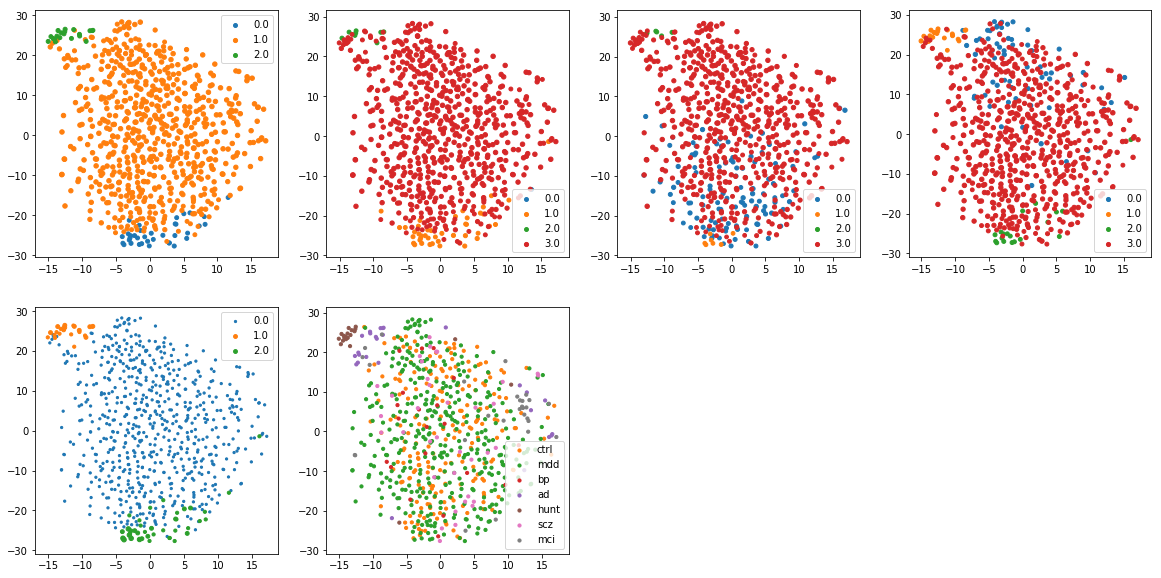

ixi


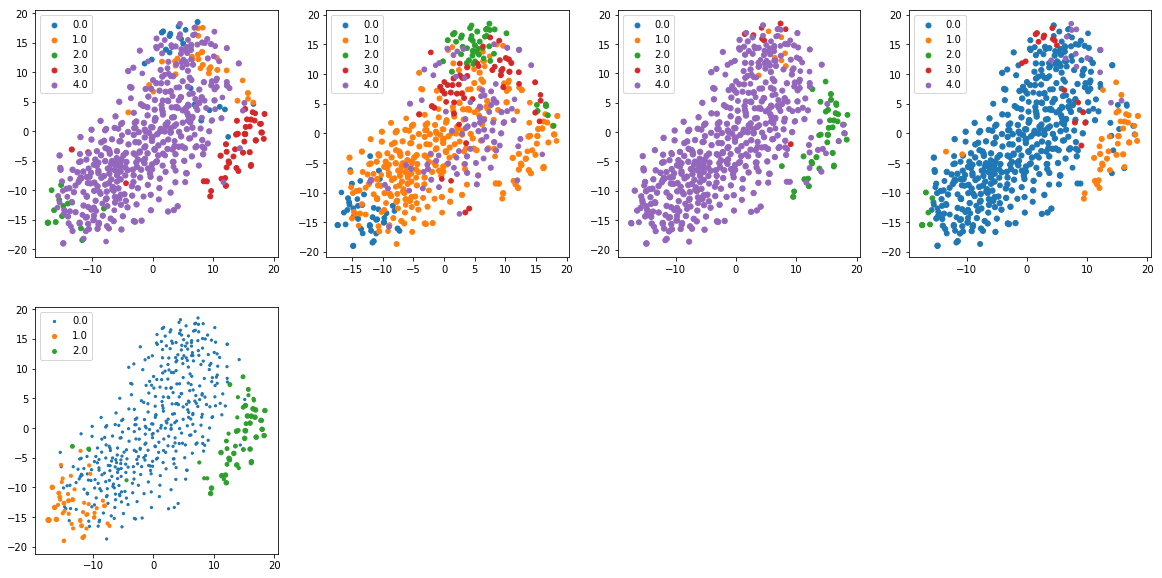

mdd ctrl


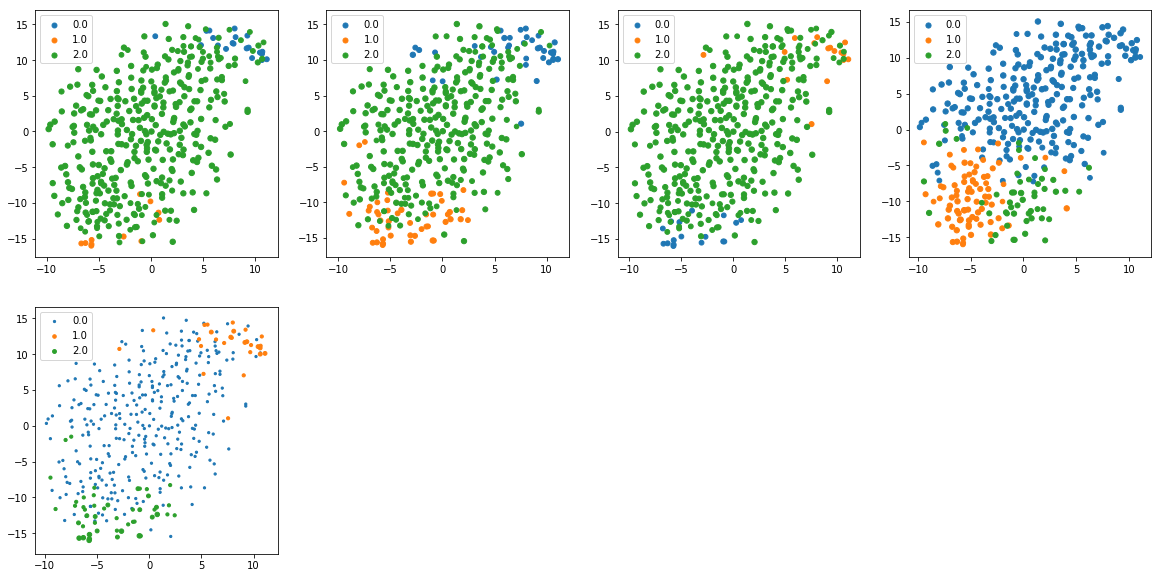

mddmdd


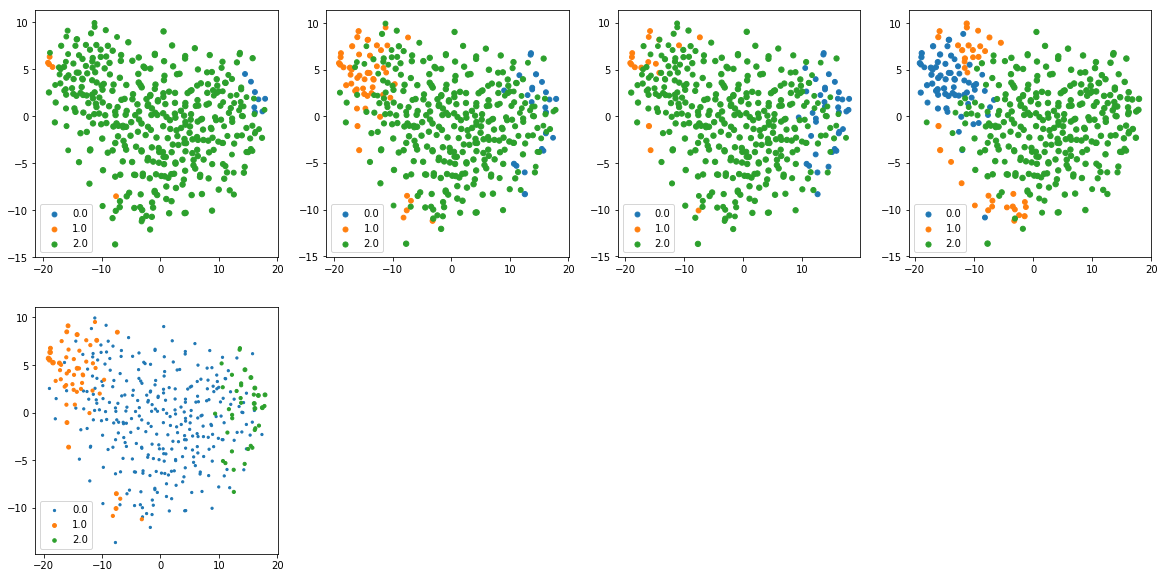

In [366]:
##
print('all')
fig = plt.figure(figsize=[20,10])
for mf in range(4):

    labels = all_labelsmain2[:,0,2,mf]
    probas = all_probamain2[:,0,2,mf]+1
    
    ax = plt.subplot(2,4,mf+1)
    colorscatter(all_tsne,labels,probas*2, ax,1)
    
ax = plt.subplot(2,4,6)
colorscatter(all_tsne,sampleidx,np.ones(740)*2, ax,0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])

assignedwhere_all, clusassig_all, balance_all = check_clus_correspondence(ALLallcorrs,ALLallmses, 5, all_labelsmain2[:,0,2,:])
ax = plt.subplot(2,4,5)
colorscatter(all_tsne,clusassig_all,balance_all+1, ax,1)
    
plt.show()

##
print('ixi')
fig = plt.figure(figsize=[20,10])
for mf in range(4):

    labels = ixi_labelsmain2[:,0,3,mf]
    probas = ixi_probamain2[:,0,3,mf]+1
    
    ax = plt.subplot(2,4,mf+1)
    colorscatter(ixi_tsne,labels,probas*3, ax,1)

assignedwhere_ixi, clusassig_ixi, balance_ixi = check_clus_correspondence(IXIallcorrs,IXIallmses, 5, ixi_labelsmain2[:,0,3,:])
ax = plt.subplot(2,4,5)
colorscatter(ixi_tsne,clusassig_ixi,balance_ixi+1, ax,1)
    
plt.show()

##
print('mdd ctrl')

fig = plt.figure(figsize=[20,10])
for mf in range(4):

    labels = mdd_ctrl_labelsmain2[:,0,1,mf]
    probas = mdd_ctrl_probamain2[:,0,1,mf]+1
    
    ax = plt.subplot(2,4,mf+1)
    colorscatter(mdd_ctrl_tsne,labels,probas*3, ax,1)
    
assignedwhere_mdd_ctrl, clusassig_mdd_ctrl, balance_mdd_ctrl = check_clus_correspondence(MDDCTRLallcorrs,MDDCTRLallmses, 5, mdd_ctrl_labelsmain2[:,0,1,:])
ax = plt.subplot(2,4,5)
colorscatter(mdd_ctrl_tsne,clusassig_mdd_ctrl,(balance_mdd_ctrl+1), ax,1)
    
plt.show()

##
print('mddmdd')

fig = plt.figure(figsize=[20,10])
for mf in range(4):

    labels = mdd_mdd_labelsmain2[:,0,1,mf]
    probas = mdd_mdd_probamain2[:,0,1,mf]+1
    
    ax = plt.subplot(2,4,mf+1)
    colorscatter(mdd_mdd_tsne,labels,probas*3, ax,1)
    
assignedwhere_mdd_mdd, clusassig_mdd_mdd, balance_mdd_mdd = check_clus_correspondence(MDDMDDallcorrs,MDDMDDallmses, 5, mdd_mdd_labelsmain2[:,0,1,:])
ax = plt.subplot(2,4,5)
colorscatter(mdd_mdd_tsne,clusassig_mdd_mdd,(balance_mdd_mdd+1), ax,1)
    
plt.show()

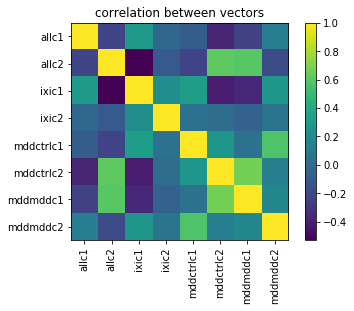

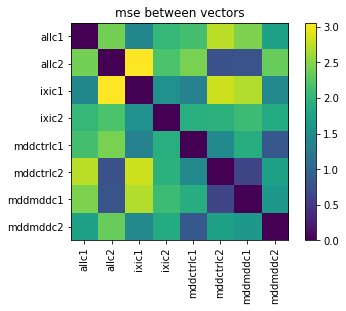

In [369]:
allvecs=[correspclus_all[0],correspclus_all[1],correspclus_ixi[0],correspclus_ixi[1],correspclus_mddctrl[0],correspclus_mddctrl[1],correspclus_mddmdd[0],correspclus_mddmdd[1]]

plt.imshow(np.corrcoef(allvecs)); plt.colorbar(); 
plt.title('correlation between vectors');
plt.xticks(np.arange(8),['allc1','allc2','ixic1','ixic2','mddctrlc1','mddctrlc2','mddmddc1','mddmddc2'],rotation='vertical')
plt.yticks(np.arange(8),['allc1','allc2','ixic1','ixic2','mddctrlc1','mddctrlc2','mddmddc1','mddmddc2'])
plt.show()

allmse = np.full([8,8],np.nan)
for n in range(8):
    for m in range(8):
        allmse[n,m]=vector_mse(allvecs[n],allvecs[m])
        
plt.imshow((allmse)); plt.colorbar(); 
plt.title('mse between vectors');
plt.xticks(np.arange(8),['allc1','allc2','ixic1','ixic2','mddctrlc1','mddctrlc2','mddmddc1','mddmddc2'],rotation='vertical')
plt.yticks(np.arange(8),['allc1','allc2','ixic1','ixic2','mddctrlc1','mddctrlc2','mddmddc1','mddmddc2'])
plt.show()

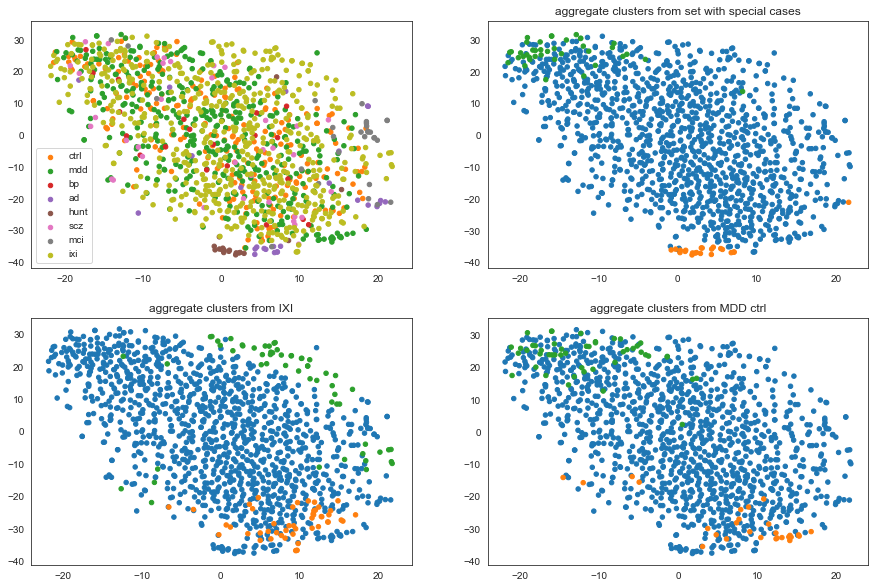

In [509]:
import seaborn as sns
sns.set_style("white")

# try plotting all data on the same plot using TSNE
fig=plt.figure(figsize=[15,10]); 
ax=plt.subplot(2,2,1);
colorscatter(mega_tsne, samplex, np.ones(1284)*4, ax, 0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci','ixi'])

# all
whereall = np.zeros(shape=[1284]); whereall[:740]=1
ax=plt.subplot(2,2,2); plt.title('aggregate clusters from set with special cases')
whereall[np.where(whereall==1)[0]]=clusassig_all
colorscatter(mega_tsne, whereall, np.ones(1284)*4, ax, 0)

#ixi
whereixi = np.zeros(shape=[1284]); whereixi[np.where(samplex==8)[0]]=1
ax=plt.subplot(2,2,3); plt.title('aggregate clusters from IXI')
whereixi[np.where(whereixi==1)[0]]=clusassig_ixi
colorscatter(mega_tsne, whereixi, np.ones(1284)*4, ax, 0)

#mdd
wheremdd = np.zeros(shape=[1284]); wheremdd[np.where(samplex==2)[0]]=1
ax=plt.subplot(2,2,4); plt.title('aggregate clusters from MDD ctrl')
wheremdd[np.where(wheremdd==1)[0]]=clusassig_mdd_ctrl
colorscatter(mega_tsne, wheremdd, np.ones(1284)*4, ax, 0)

#wheremdd = np.zeros(shape=[1284]); wheremdd[np.where(samplex==2)[0]]=1
#ax=plt.subplot(3,2,6); plt.title('aggregate clusters from MDD mdd')
#wheremdd[np.where(wheremdd==1)[0]]=clusassig_mdd_mdd
#colorscatter(mega_tsne, wheremdd, np.ones(1284)*4, ax, 0)

plt.show()

In [418]:
rs1=[]
rs2=[]
for f in range(82):
    rs1.append(np.corrcoef(MEGADATA[:,f],mega_tsne[:,0])[0,1])
    rs2.append(np.corrcoef(MEGADATA[:,f],mega_tsne[:,1])[0,1])

wrs1=np.where(abs(np.array(rs1))==np.max(abs(np.array(rs1))))[0]
wrs2=np.where(abs(np.array(rs2))==np.max(abs(np.array(rs2))))[0]

print(wrs1,Tclabels[wrs1],np.array(rs1)[wrs1])
print(wrs2,Tclabels[wrs2],np.array(rs2)[wrs2])

[25] [['L_rostralmiddlefrontal_thickavg']] [-0.59552619]
[57] [['R_precuneus_thickavg']] [0.73951528]


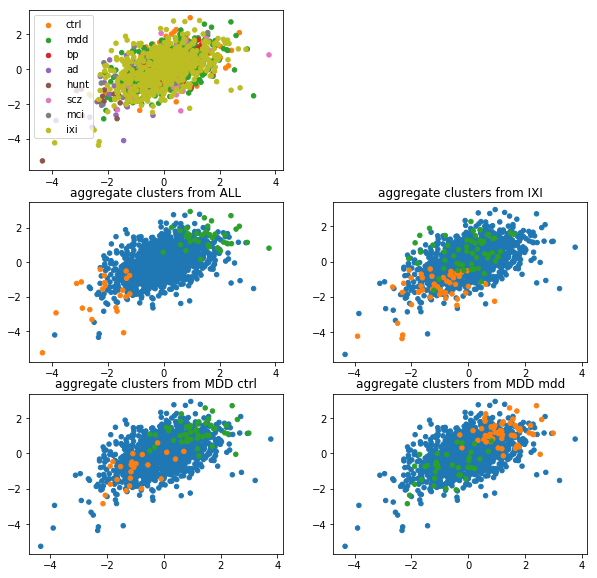

In [394]:
X2use = MEGADATA[:,[25,57]]

# try plotting all data on the same plot using TSNE
fig=plt.figure(figsize=[10,10]); 
ax=plt.subplot(3,2,1);
colorscatter(X2use, samplex, np.ones(1284)*4, ax, 0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci','ixi'])

# all
whereall = np.zeros(shape=[1284]); whereall[:740]=1
ax=plt.subplot(3,2,3); plt.title('aggregate clusters from ALL')
whereall[np.where(whereall==1)[0]]=clusassig_all
colorscatter(X2use, whereall, np.ones(1284)*4, ax, 0)

#ixi
whereixi = np.zeros(shape=[1284]); whereixi[np.where(samplex==8)[0]]=1
ax=plt.subplot(3,2,4); plt.title('aggregate clusters from IXI')
whereixi[np.where(whereixi==1)[0]]=clusassig_ixi
colorscatter(X2use, whereixi, np.ones(1284)*4, ax, 0)

#mdd
wheremdd = np.zeros(shape=[1284]); wheremdd[np.where(samplex==2)[0]]=1
ax=plt.subplot(3,2,5); plt.title('aggregate clusters from MDD ctrl')
wheremdd[np.where(wheremdd==1)[0]]=clusassig_mdd_ctrl
colorscatter(X2use, wheremdd, np.ones(1284)*4, ax, 0)

wheremdd = np.zeros(shape=[1284]); wheremdd[np.where(samplex==2)[0]]=1
ax=plt.subplot(3,2,6); plt.title('aggregate clusters from MDD mdd')
wheremdd[np.where(wheremdd==1)[0]]=clusassig_mdd_mdd
colorscatter(X2use, wheremdd, np.ones(1284)*4, ax, 0)

plt.show()

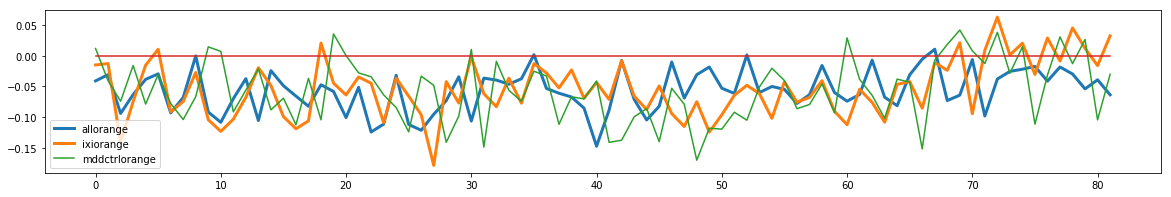

In [432]:
fig=plt.figure(figsize=[20,3]); 
plt.plot(allvecs[0],linewidth=3.0)
plt.plot(allvecs[2],linewidth=3.0)
plt.plot(allvecs[4])
plt.plot(np.zeros(82))
plt.legend(['allorange','ixiorange','mddctrlorange'])
plt.show()

all: 0.08473371668527593
ixi: 0.09431952477018009
mdd: 0.10353267608978799


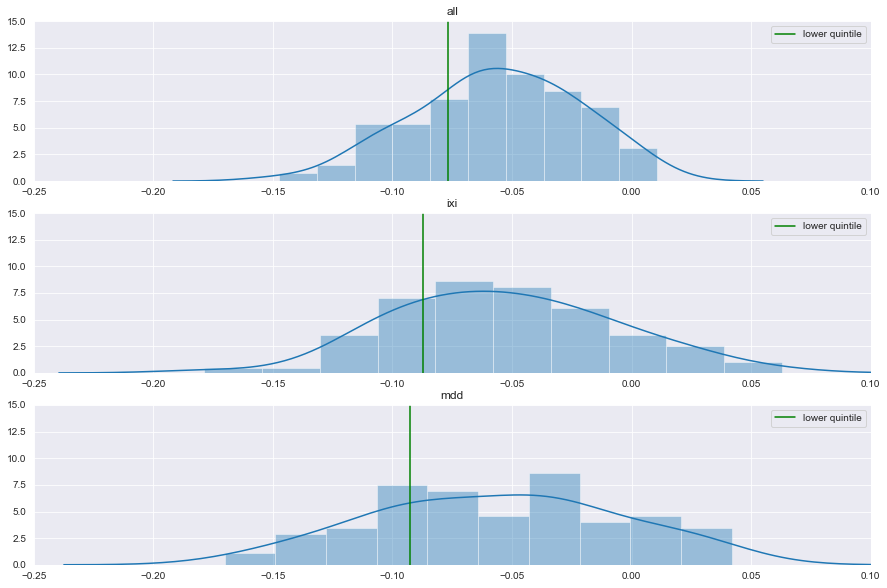

In [493]:
import seaborn as sns
sns.set_style("darkgrid")
bins2use=np.linspace(-.25,.15,50)
fig=plt.figure(figsize=[15,10])
plt.subplot(3,1,1); 
sns.distplot(allvecs[0], bins=10); 
plt.axvline(-np.percentile(abs(allvecs[0]),75), 0, 15, c='g', label='lower quintile'); plt.legend()
plt.title('all'); plt.xlim([-.25,.1]); plt.ylim([0,15]); 

plt.subplot(3,1,2); 
sns.distplot(allvecs[2], bins=10); 
plt.axvline(-np.percentile(abs(allvecs[2]),75), 0, 15, c='g', label='lower quintile'); plt.legend()
plt.title('ixi'); plt.xlim([-.25,.1]); plt.ylim([0,15])

plt.subplot(3,1,3); 
sns.distplot(allvecs[4], bins=10); 
plt.axvline(-np.percentile(abs(allvecs[4]),75), 0, 15, c='g', label='lower quintile'); plt.legend()
plt.title('mdd'); plt.xlim([-.25,.1]); plt.ylim([0,15])

print('all:',np.percentile(abs(allvecs[0]),80))
print('ixi:',np.percentile(abs(allvecs[2]),80))
print('mdd:',np.percentile(abs(allvecs[4]),80))

In [504]:
print('allorange and ixiorange:')
spit_out_vector_overlap(allvecs[0],allvecs[2], 20,0)
print('\nallorange and mddctrlorange:')
spit_out_vector_overlap(allvecs[0],allvecs[4], 20,0)
print('\nixiorange and mddctrlorange:')
spit_out_vector_overlap(allvecs[2],allvecs[4], 20,0)

allorange and ixiorange:
Pearsons correlation between the two vectors: 0.2919399740448574 (p= 0.0077842645989434365 )
Features that were in the top 20& of contributors in both vectors:
	 2 ['L_caudalmiddlefrontal_thickavg'] -0.09401668145160505 -0.14101690883271775
	 9 ['L_lateraloccipital_thickavg'] -0.09173966527654612 -0.10427391971496164
	 10 ['L_lateralorbitofrontal_thickavg'] -0.10841472776156845 -0.12323370726182648
	 23 ['L_precuneus_thickavg'] -0.11137410715555202 -0.10904130912347493
	 26 ['L_superiorfrontal_thickavg'] -0.12140020555895126 -0.09615663046064489
	 27 ['L_superiorparietal_thickavg'] -0.09532882850446847 -0.178614837451458

allorange and mddctrlorange:
Pearsons correlation between the two vectors: -0.07904093573395897 (p= 0.48027302571075337 )

ixiorange and mddctrlorange:
Pearsons correlation between the two vectors: 0.32192109893783977 (p= 0.003184871679191751 )
Features that were in the top 20& of contributors in both vectors:
	 16 ['L_parsopercularis_thickavg

[1, 1, 0, 8, 11, 0, 1]
[10, 23, 1, 1, 0, 2, 2]
contingency matrix for assignments of MDD in ALL and in MDDctrl
[[321  26  27]
 [  0   1   0]
 [  2   0  21]]

allc2 and mddctrlc2:
Pearsons correlation between the two vectors: 0.6197784976859522 (p= 5.350229312784876e-10 )


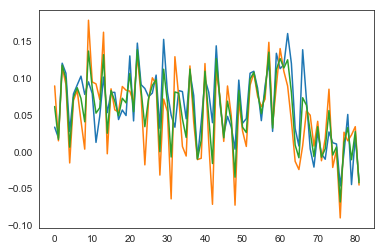

Features that were in the top 20& of contributors in both vectors:
	 2 ['L_caudalmiddlefrontal_thickavg'] 0.12030150711942254 0.11522719491491655
	 3 ['L_cuneus_thickavg'] 0.10664072673920126 0.09127454107867096
	 22 ['L_precentral_thickavg'] 0.14761176712382593 0.12980098568029783
	 27 ['L_superiorparietal_thickavg'] 0.10415054992621674 0.09184028921306803
	 36 ['R_caudalmiddlefrontal_thickavg'] 0.10799288572316422 0.1166242285867884
	 43 ['R_lateraloccipital_thickavg'] 0.1439037474330696 0.10926317599049724
	 53 ['R_pericalcarine_thickavg'] 0.10935846366476283 0.10664505907041645
	 57 ['R_precuneus_thickavg'] 0.12193852569650498 0.14869522320178488
	 60 ['R_superiorfrontal_thickavg'] 0.11288430786970317 0.14020431427736668
	 61 ['R_superiorparietal_thickavg'] 0.11847166882702705 0.10919013930540872


In [651]:
# from the diagnoses, who is in the clusters for ALL?
allc1_dgx = sampleidx[np.where(clusassig_all==1)[0]]
allc2_dgx = sampleidx[np.where(clusassig_all==2)[0]]

dgxs=['ctrl','mdd','bp','ad','hunt','scz','mci']
print([len(np.where(allc1_dgx==i+1)[0]) for i in range(7)])
print([len(np.where(allc2_dgx==i+1)[0]) for i in range(7)])

# are the same folks retrieved for ALL cluster 2 and MDDctrl cluster 2?
mdd_fromall = clusassig_all[np.where(sampleidx==2)[0]]
conmat = contingency_matrix(mdd_fromall, clusassig_mdd_ctrl)
print('contingency matrix for assignments of MDD in ALL and in MDDctrl')
print(conmat)
# this means that all 21 of 23 who were assigned to cluster 2 in the ALL sample 
# were also assigned to cluster 2 in the MDDctrl sample.
# however 27 people who were assigned to 2 in MDDctrl were not in ALL.
print('\nallc2 and mddctrlc2:')
spit_out_vector_overlap(allvecs[1],allvecs[5], 20,1)

In [526]:
# are there any copvariate effects lurking? especially for IXI
find_ixic2 = np.where(clusassig_ixi==2)[0]
cert_ixic2 = abs(balance_ixi[find_ixic2])

ixis3 = pd.read_csv('/Users/lee_jollans/Projects/clustering_pilot/ixi_s3_outliers_nans_removed.csv')
ixis3.head()

ALL_IDs  L_bankssts_surfavg  L_caudalanteriorcingulate_surfavg  \
0  IXI002                1014                                640   
1  IXI012                 969                                734   
2  IXI013                1044                                608   
3  IXI014                 969                                514   
4  IXI015                1044                                564   

   L_caudalmiddlefrontal_surfavg  L_cuneus_surfavg  L_entorhinal_surfavg  \
0                           2422              1263                   435   
1                           2093              2004                   429   
2                           2999              1436                   451   
3                           2167              1544                   487   
4                           2364              1245                   535   

   L_fusiform_surfavg  L_inferiorparietal_surfavg  L_inferiortemporal_surfavg  \
0                2761                        4097                        3110   
1                4012                        4345                        3826   
2                3909                        4112                        3685   
3                3223                        3555                        3057   
4                3049                        4837                        3555   

   L_isthmuscingulate_surfavg  ...  IXI_ID_STRING  IXI_ID  sex_pheno  HEIGHT  \
0                         784  ...         IXI002       2          2     164   
1                        1134  ...         IXI012      12          1     175   
2                        1227  ...         IXI013      13          1     182   
3                         880  ...         IXI014      14          2     163   
4                        1117  ...         IXI015      15          1     181   

   WEIGHT  Ethnicity  MARITAL_ID  OCCUPATION_ID  QUALIFICATION_ID  \
0      58          1           4              1                 5   
1      70          1           2              1                 5   
2      70          1           2              1                 5   
3      65          1           4              1                 5   
4      90          2           1              6                 5   

   consensusage_pheno  
0           35.800137  
1           38.781656  
2           46.710472  
3           34.236824  
4           24.284736  

[5 rows x 184 columns]

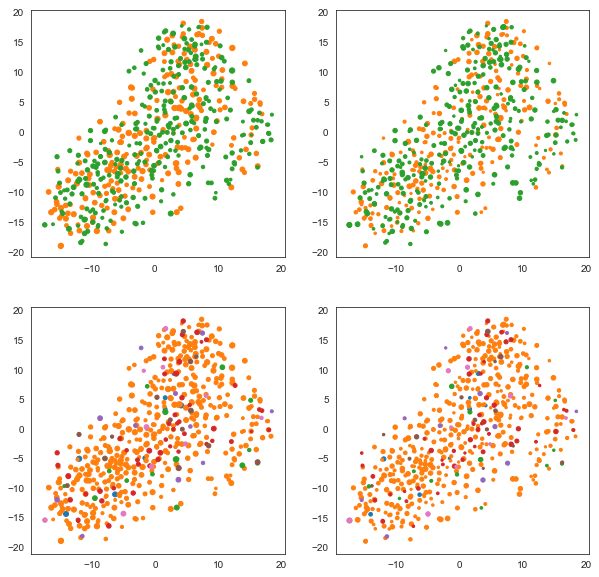

check for diff between null and cluster 1
t-test for differences in icv: t= [-1.0528164] p= [0.29294938]
t-test for differences in age: t= [0.51691396] p= [0.60545185]
t-test for differences in sex: t= 0.9205669096449103 p= 0.35773423546229166
t-test for differences in ethnicity: t= -0.7694065770634645 p= 0.4420265291405462
check for diff between null and cluster 2
t-test for differences in icv: t= [3.88097312] p= [0.00011815]
t-test for differences in age: t= [2.95417347] p= [0.00328463]
t-test for differences in sex: t= -1.6865290787863503 p= 0.09232529921849011
t-test for differences in ethnicity: t= -0.7175362197620176 p= 0.4733824515557622
check for diff between cluster 1 and cluster 2
t-test for differences in icv: t= [3.73641832] p= [0.0003066]
t-test for differences in age: t= [1.77608183] p= [0.07867234]
t-test for differences in sex: t= -1.9566427037680927 p= 0.05309686460115591
t-test for differences in ethnicity: t= 0.08282127898287285 p= 0.9341543905354606


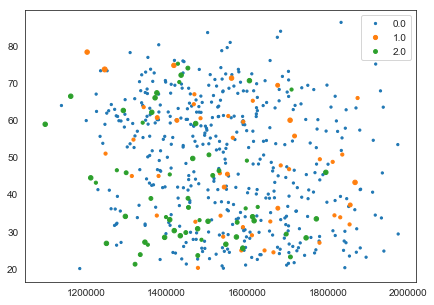

In [629]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

icv = scaler.fit_transform(np.expand_dims(np.array(ixis3['ICV_x'].values),axis=1))
age = scaler.fit_transform(np.expand_dims(np.array(ixis3['consensusage_pheno'].values),axis=1))
sex = ixis3['sex_pheno'].values
ethnicity = ixis3['Ethnicity'].values
            
fig=plt.figure(figsize=[10,10])
ax=plt.subplot(2,2,1)
colorscatter(ixi_tsne,sex,(icv-np.min(icv)+1),ax,0)
ax=plt.subplot(2,2,2)
colorscatter(ixi_tsne,sex,(age-np.min(age)+1),ax,0)
ax=plt.subplot(2,2,3)
colorscatter(ixi_tsne,ethnicity,(icv-np.min(icv)+1),ax,0)
ax=plt.subplot(2,2,4)
colorscatter(ixi_tsne,ethnicity,(age-np.min(age)+1),ax,0)
plt.show()

for c in [1,2]:
    print('check for diff between null and cluster ' + str(c))
    t,p = scipy.stats.ttest_ind(icv[np.where(clusassig_ixi==0)[0]],icv[np.where(clusassig_ixi==c)[0]])
    print('t-test for differences in icv: t=', t, 'p=', p)
    t,p = scipy.stats.ttest_ind(age[np.where(clusassig_ixi==0)[0]],age[np.where(clusassig_ixi==c)[0]])
    print('t-test for differences in age: t=', t, 'p=', p)
    t,p = scipy.stats.ttest_ind(sex[np.where(clusassig_ixi==0)[0]],sex[np.where(clusassig_ixi==c)[0]])
    print('t-test for differences in sex: t=', t, 'p=', p)
    t,p = scipy.stats.ttest_ind(ethnicity[np.where(clusassig_ixi==0)[0]],ethnicity[np.where(clusassig_ixi==c)[0]])
    print('t-test for differences in ethnicity: t=', t, 'p=', p)

print('check for diff between cluster 1 and cluster 2')
t,p = scipy.stats.ttest_ind(icv[np.where(clusassig_ixi==1)[0]],icv[np.where(clusassig_ixi==c)[0]])
print('t-test for differences in icv: t=', t, 'p=', p)
t,p = scipy.stats.ttest_ind(age[np.where(clusassig_ixi==1)[0]],age[np.where(clusassig_ixi==c)[0]])
print('t-test for differences in age: t=', t, 'p=', p)
t,p = scipy.stats.ttest_ind(sex[np.where(clusassig_ixi==1)[0]],sex[np.where(clusassig_ixi==c)[0]])
print('t-test for differences in sex: t=', t, 'p=', p)
t,p = scipy.stats.ttest_ind(ethnicity[np.where(clusassig_ixi==1)[0]],ethnicity[np.where(clusassig_ixi==c)[0]])
print('t-test for differences in ethnicity: t=', t, 'p=', p)

fig=plt.figure(figsize=[7,5])
ax=plt.subplot(1,1,1)
colorscatter(np.array([ixis3['ICV_x'].values,ixis3['consensusage_pheno'].values]).T, clusassig_ixi, balance_ixi+1,ax,1)

In [607]:
# do the same thing for the other samples
alls3 = pd.read_csv('/Users/lee_jollans/Projects/clustering_pilot/ALL/ALL_covars.csv',header=None)
alls3.columns=['ICV','age','sex','site','age2']
alls3.head()

ICV  age  sex  site  age2
0  1494570   23    2     1   552
1  1322510   37    2     1  1406
2  1383470   66    2     1  4356
3  1526270   23    2     1   529
4  1623460   32    2     1  1056

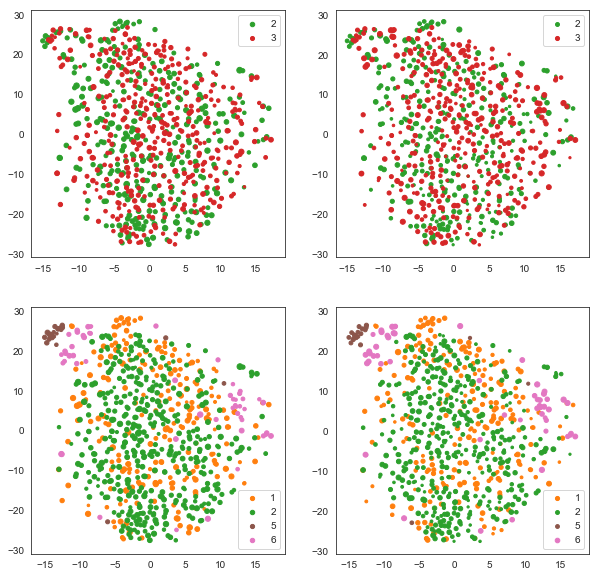

check for diff between null and cluster 1
t-test for differences in icv: t= [-0.25681566] p= [0.79739665]
t-test for differences in age: t= [-2.38939219] p= [0.01714038]
t-test for differences in sex: t= 0.1180540974113073 p= 0.9060587088450998
check for diff between null and cluster 2
t-test for differences in icv: t= [-1.71530752] p= [0.08672151]
t-test for differences in age: t= [-0.03838323] p= [0.96939283]
t-test for differences in sex: t= 2.1218264217603537 p= 0.03419513726557443
check for diff between cluster 1 and cluster 2
t-test for differences in icv: t= [-0.8002814] p= [0.42675848]
t-test for differences in age: t= [1.68112745] p= [0.09802516]
t-test for differences in sex: t= 1.209079623639306 p= 0.23145527138367178


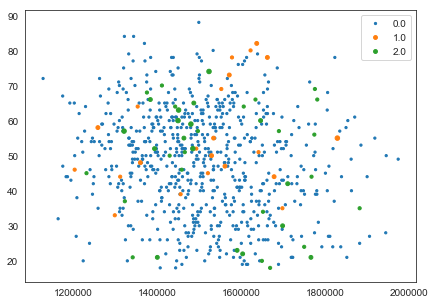

In [630]:
icv = scaler.fit_transform(np.expand_dims(np.array(alls3['ICV'].values),axis=1))
age = scaler.fit_transform(np.expand_dims(np.array(alls3['age'].values),axis=1))
sex = alls3['sex'].values
site = alls3['site'].values
            
fig=plt.figure(figsize=[10,10])
ax=plt.subplot(2,2,1)
colorscatter(all_tsne,sex+1,(icv-np.min(icv)+1)*1,ax,1)
ax=plt.subplot(2,2,2)
colorscatter(all_tsne,sex+1,(age-np.min(age)+1)*1,ax,1)
ax=plt.subplot(2,2,3)
colorscatter(all_tsne,site+1,(icv-np.min(icv)+1)*1,ax,1)
ax=plt.subplot(2,2,4)
colorscatter(all_tsne,site+1,(age-np.min(age)+1)*1,ax,1)
plt.show()

for c in [1,2]:
    print('check for diff between null and cluster ' + str(c))
    t,p = scipy.stats.ttest_ind(icv[np.where(clusassig_all==0)[0]],icv[np.where(clusassig_all==c)[0]])
    print('t-test for differences in icv: t=', t, 'p=', p)
    t,p = scipy.stats.ttest_ind(age[np.where(clusassig_all==0)[0]],age[np.where(clusassig_all==c)[0]])
    print('t-test for differences in age: t=', t, 'p=', p)
    t,p = scipy.stats.ttest_ind(sex[np.where(clusassig_all==0)[0]],sex[np.where(clusassig_all==c)[0]])
    print('t-test for differences in sex: t=', t, 'p=', p)


print('check for diff between cluster 1 and cluster 2')
t,p = scipy.stats.ttest_ind(icv[np.where(clusassig_all==1)[0]],icv[np.where(clusassig_all==c)[0]])
print('t-test for differences in icv: t=', t, 'p=', p)
t,p = scipy.stats.ttest_ind(age[np.where(clusassig_all==1)[0]],age[np.where(clusassig_all==c)[0]])
print('t-test for differences in age: t=', t, 'p=', p)
t,p = scipy.stats.ttest_ind(sex[np.where(clusassig_all==1)[0]],sex[np.where(clusassig_all==c)[0]])
print('t-test for differences in sex: t=', t, 'p=', p)


fig=plt.figure(figsize=[7,5])
ax=plt.subplot(1,1,1)
colorscatter(np.array([alls3['ICV'].values,alls3['age'].values]).T, clusassig_all, balance_all+1,ax,1)

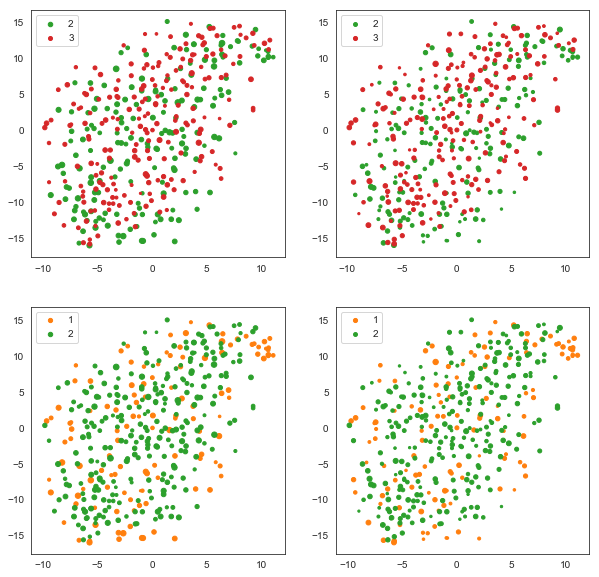

check for diff between null and cluster 1
t-test for differences in icv: t= [1.89013324] p= [0.0595709]
t-test for differences in age: t= [-1.05912808] p= [0.29027603]
t-test for differences in sex: t= 0.8540368974342472 p= 0.39367204559926894
check for diff between null and cluster 2
t-test for differences in icv: t= [-0.76882629] p= [0.44248823]
t-test for differences in age: t= [-0.07324559] p= [0.94165037]
t-test for differences in sex: t= 2.4996044322977506 p= 0.012866763614806166
check for diff between cluster 1 and cluster 2
t-test for differences in icv: t= [-2.05301388] p= [0.04365544]
t-test for differences in age: t= [0.79987333] p= [0.42637944]
t-test for differences in sex: t= 0.8916262819476573 p= 0.3755228166429412


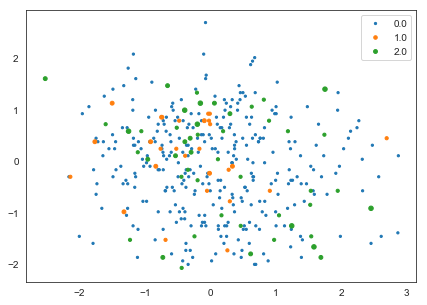

In [631]:
if len(age)!=398:
    wheremdd = np.zeros(shape=[740]); wheremdd[np.where(sampleidx==2)[0]]=1
    age = age[np.where(wheremdd==1)[0]]
    icv = icv[np.where(wheremdd==1)[0]]
    sex = sex[np.where(wheremdd==1)[0]]
    site = site[np.where(wheremdd==1)[0]]

fig=plt.figure(figsize=[10,10])
ax=plt.subplot(2,2,1)
colorscatter(mdd_ctrl_tsne,sex+1,(icv-np.min(icv)+1)*1,ax,1)
ax=plt.subplot(2,2,2)
colorscatter(mdd_ctrl_tsne,sex+1,(age-np.min(age)+1)*1,ax,1)
ax=plt.subplot(2,2,3)
colorscatter(mdd_ctrl_tsne,site+1,(icv-np.min(icv)+1)*1,ax,1)
ax=plt.subplot(2,2,4)
colorscatter(mdd_ctrl_tsne,site+1,(age-np.min(age)+1)*1,ax,1)
plt.show()


for c in [1,2]:
    print('check for diff between null and cluster ' + str(c))
    t,p = scipy.stats.ttest_ind(icv[np.where(clusassig_mdd_ctrl==0)[0]],icv[np.where(clusassig_mdd_ctrl==c)[0]])
    print('t-test for differences in icv: t=', t, 'p=', p)
    t,p = scipy.stats.ttest_ind(age[np.where(clusassig_mdd_ctrl==0)[0]],age[np.where(clusassig_mdd_ctrl==c)[0]])
    print('t-test for differences in age: t=', t, 'p=', p)
    t,p = scipy.stats.ttest_ind(sex[np.where(clusassig_mdd_ctrl==0)[0]],sex[np.where(clusassig_mdd_ctrl==c)[0]])
    print('t-test for differences in sex: t=', t, 'p=', p)


print('check for diff between cluster 1 and cluster 2')
t,p = scipy.stats.ttest_ind(icv[np.where(clusassig_mdd_ctrl==1)[0]],icv[np.where(clusassig_mdd_ctrl==c)[0]])
print('t-test for differences in icv: t=', t, 'p=', p)
t,p = scipy.stats.ttest_ind(age[np.where(clusassig_mdd_ctrl==1)[0]],age[np.where(clusassig_mdd_ctrl==c)[0]])
print('t-test for differences in age: t=', t, 'p=', p)
t,p = scipy.stats.ttest_ind(sex[np.where(clusassig_mdd_ctrl==1)[0]],sex[np.where(clusassig_mdd_ctrl==c)[0]])
print('t-test for differences in sex: t=', t, 'p=', p)


fig=plt.figure(figsize=[7,5])
ax=plt.subplot(1,1,1)
colorscatter(np.squeeze(np.array([icv,age])).T, clusassig_mdd_ctrl, balance_mdd_ctrl+1,ax,1)

[[2. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 2. 1. 0.]
 [0. 1. 2. 0.]]


/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


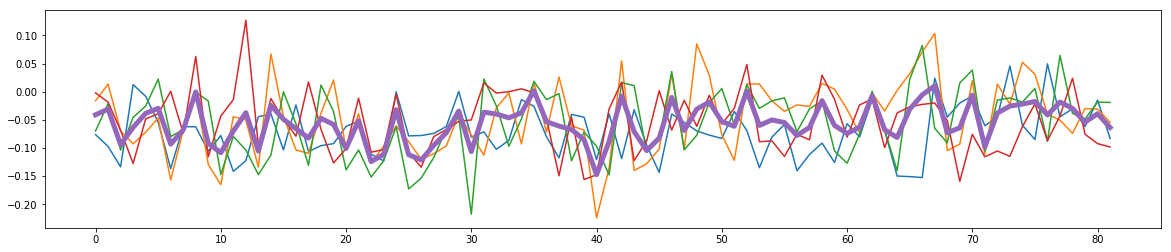

22 ['L_precentral_thickavg'] -0.1242207875708679
23 ['L_precuneus_thickavg'] -0.11137410715555202
25 ['L_rostralmiddlefrontal_thickavg'] -0.11193788019131683
26 ['L_superiorfrontal_thickavg'] -0.12140020555895126
40 ['R_inferiorparietal_thickavg'] -0.14740871955990795


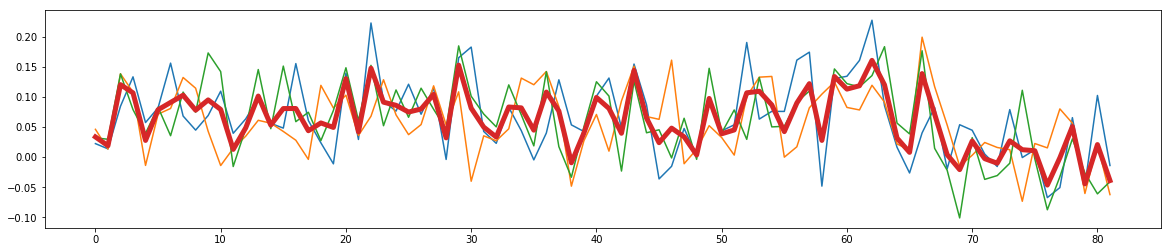

22 ['L_precentral_thickavg'] 0.14761176712382593
29 ['L_supramarginal_thickavg'] 0.15265989408077937
43 ['R_lateraloccipital_thickavg'] 0.1439037474330696
62 ['R_superiortemporal_thickavg'] 0.1606048804697759
66 ['R_transversetemporal_thickavg'] 0.13862771643697633


In [281]:
# ALL:
assignedwhere, clusassig, balance = check_clus_correspondence(ALLallcorrs,ALLallmses, 5, all_labelsmain2[:,0,2,:])
print(assignedwhere)

correspclus_all=[]
for cloop in range(np.max(assignedwhere).astype(int)):
    tmp=[]
    a=np.where(assignedwhere==cloop+1)
    for n in range(len(a[0])):
        tmp.append(all_betas[1:,a[1][n],a[0][n]])
    tmp=np.array(tmp)
    correspclus_all.append(np.nanmean(tmp,axis=0))
    
    fig=plt.figure(figsize=[20,4])
    plt.plot(tmp.T); 
    plt.plot(np.nanmean(tmp,axis=0),linewidth=5.0)
    plt.show()
    maxvals_beta(np.nanmean(tmp,axis=0))
assignedwhere_all = assignedwhere

[[0. 0. 1. 2. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 2. 0. 0.]
 [0. 2. 1. 0. 0.]]


/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


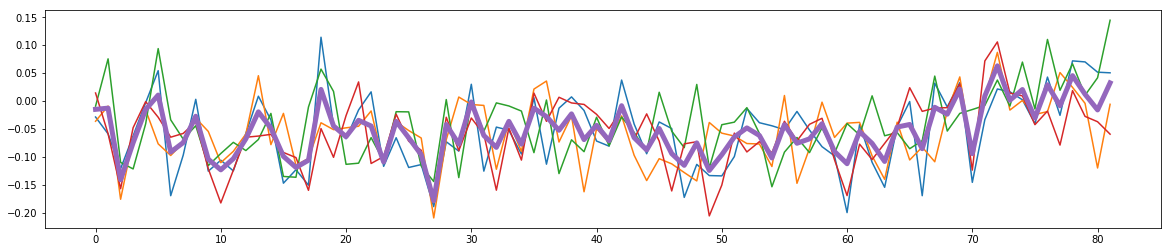

2 ['L_caudalmiddlefrontal_thickavg'] -0.14101690883271775
10 ['L_lateralorbitofrontal_thickavg'] -0.12323370726182648
16 ['L_parsopercularis_thickavg'] -0.1189436776087003
27 ['L_superiorparietal_thickavg'] -0.178614837451458
49 ['R_paracentral_thickavg'] -0.12435928270198027


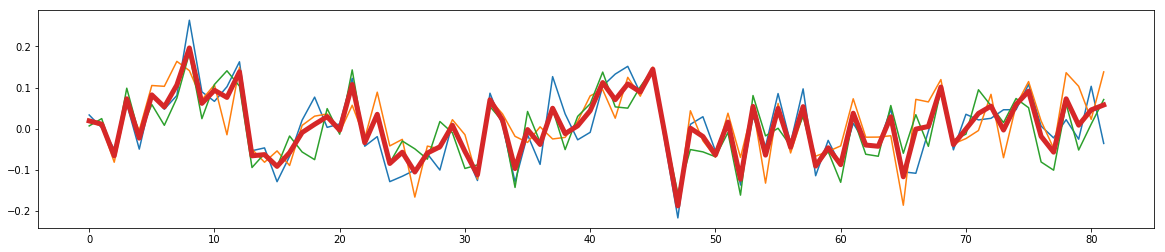

8 ['L_isthmuscingulate_thickavg'] 0.1962483981035835
12 ['L_medialorbitofrontal_thickavg'] 0.13818568311520926
45 ['R_lingual_thickavg'] 0.1446428132039156
47 ['R_middletemporal_thickavg'] -0.188110857931471
52 ['R_parstriangularis_thickavg'] -0.12309703411766491


In [283]:
# IXI:
assignedwhere = check_clus_correspondence(IXIallcorrs,IXIallmses, 5)
print(assignedwhere)

correspclus_ixi=[]
for cloop in range(np.max(assignedwhere).astype(int)):
    tmp=[]
    a=np.where(assignedwhere==cloop+1)
    for n in range(len(a[0])):
        tmp.append(ixi_betas[1:,a[1][n],a[0][n]])
    tmp=np.array(tmp)
    correspclus_ixi.append(np.nanmean(tmp,axis=0))
    
    fig=plt.figure(figsize=[20,4])
    plt.plot(tmp.T); 
    plt.plot(np.nanmean(tmp,axis=0),linewidth=5.0)
    plt.show()
    maxvals_beta(np.nanmean(tmp,axis=0))
assignedwhere_ixi = assignedwhere

[[1. 2. 0.]
 [0. 2. 0.]
 [2. 1. 0.]
 [0. 0. 0.]]


/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


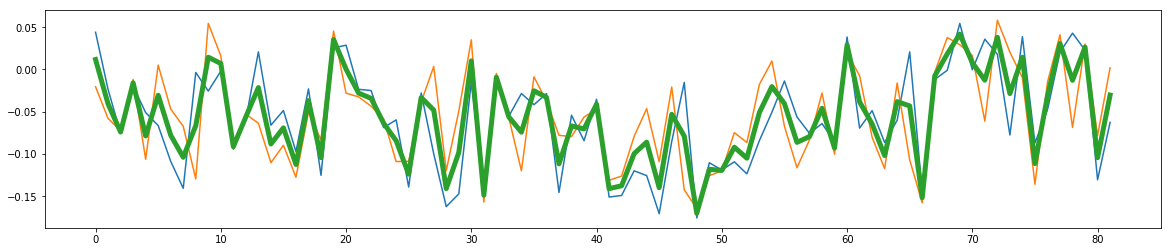

28 ['L_superiortemporal_thickavg'] -0.14101610281963495
31 ['L_temporalpole_thickavg'] -0.14880192180003557
41 ['R_inferiortemporal_thickavg'] -0.14107263750628993
48 ['R_parahippocampal_thickavg'] -0.1701448278208918
66 ['R_transversetemporal_thickavg'] -0.1517819855640944


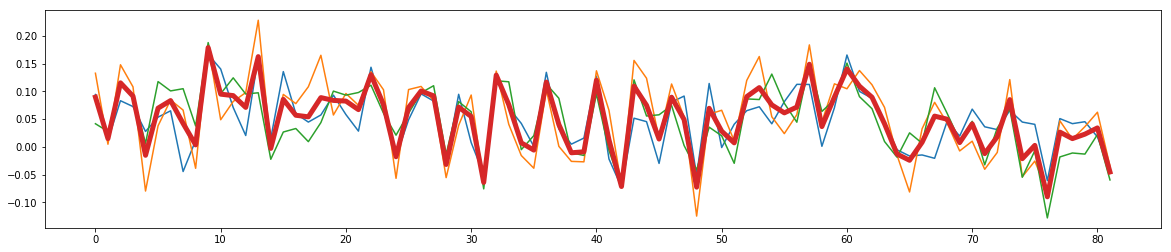

9 ['L_lateraloccipital_thickavg'] 0.1786710115465092
13 ['L_middletemporal_thickavg'] 0.16239505487972403
22 ['L_precentral_thickavg'] 0.12980098568029783
57 ['R_precuneus_thickavg'] 0.14869522320178488
60 ['R_superiorfrontal_thickavg'] 0.14020431427736668


In [285]:
# MDD CTRL:
assignedwhere = check_clus_correspondence(MDDCTRLallcorrs,MDDCTRLallmses, 5)
print(assignedwhere)

correspclus_mddctrl=[]
for cloop in range(np.max(assignedwhere).astype(int)):
    tmp=[]
    a=np.where(assignedwhere==cloop+1)
    for n in range(len(a[0])):
        tmp.append(mdd_ctrl_betas[1:,a[1][n],a[0][n]])
    tmp=np.array(tmp)
    correspclus_mddctrl.append(np.nanmean(tmp,axis=0))
    
    fig=plt.figure(figsize=[20,4])
    plt.plot(tmp.T); 
    plt.plot(np.nanmean(tmp,axis=0),linewidth=5.0)
    plt.show()
    maxvals_beta(np.nanmean(tmp,axis=0))
assignedwhere_mddctrl = assignedwhere

[[2. 1. 0.]
 [0. 1. 0.]
 [2. 1. 0.]
 [0. 0. 0.]]


/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


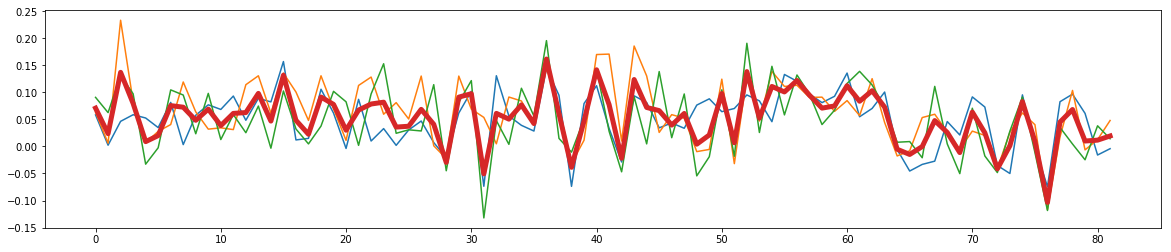

2 ['L_caudalmiddlefrontal_thickavg'] 0.13698209058602842
15 ['L_paracentral_thickavg'] 0.13167153852687447
36 ['R_caudalmiddlefrontal_thickavg'] 0.1616010181019052
40 ['R_inferiorparietal_thickavg'] 0.14170305030453806
52 ['R_parstriangularis_thickavg'] 0.1383594642249538


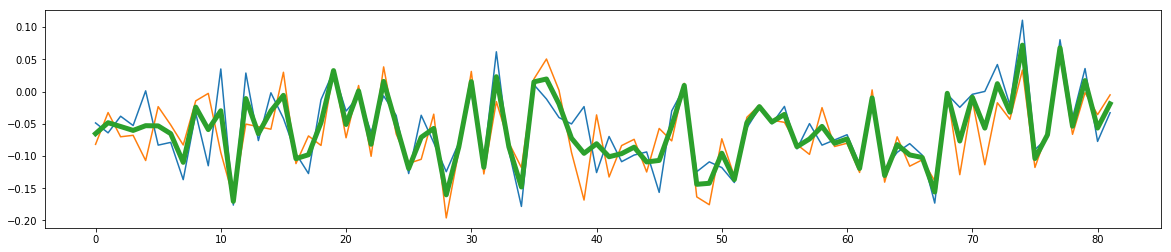

11 ['L_lingual_thickavg'] -0.17033632379502783
28 ['L_superiortemporal_thickavg'] -0.16020970411512042
34 ['R_bankssts_thickavg'] -0.1480794925245571
48 ['R_parahippocampal_thickavg'] -0.1439052654943187
67 ['R_insula_thickavg'] -0.15580747640614845


In [287]:
# MDD MDD:
assignedwhere = check_clus_correspondence(MDDMDDallcorrs,MDDMDDallmses, 5)
print(assignedwhere)

correspclus_mddmdd=[]
for cloop in range(np.max(assignedwhere).astype(int)):
    tmp=[]
    a=np.where(assignedwhere==cloop+1)
    for n in range(len(a[0])):
        tmp.append(mdd_mdd_betas[1:,a[1][n],a[0][n]])
    tmp=np.array(tmp)
    correspclus_mddmdd.append(np.nanmean(tmp,axis=0))
    
    fig=plt.figure(figsize=[20,4])
    plt.plot(tmp.T); 
    plt.plot(np.nanmean(tmp,axis=0),linewidth=5.0)
    plt.show()
    maxvals_beta(np.nanmean(tmp,axis=0))
assignedwhere_mddmdd = assignedwhere

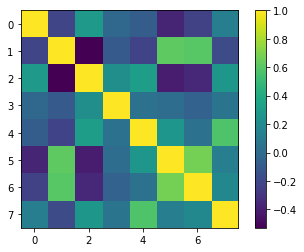

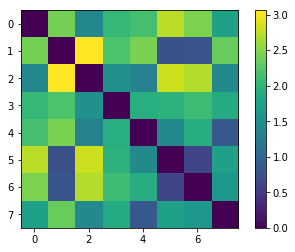

In [239]:
import csv
with open(('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/allvecs.csv'),mode='w') as file:
    filewriter=csv.writer(file,delimiter=',')
    filewriter.writerows(allvecs)
file.close()

In [240]:
# mddctrlc2, mddmddc2 and allc2 are quite similar

pattern of error between the core cluster patterns for the four datasets


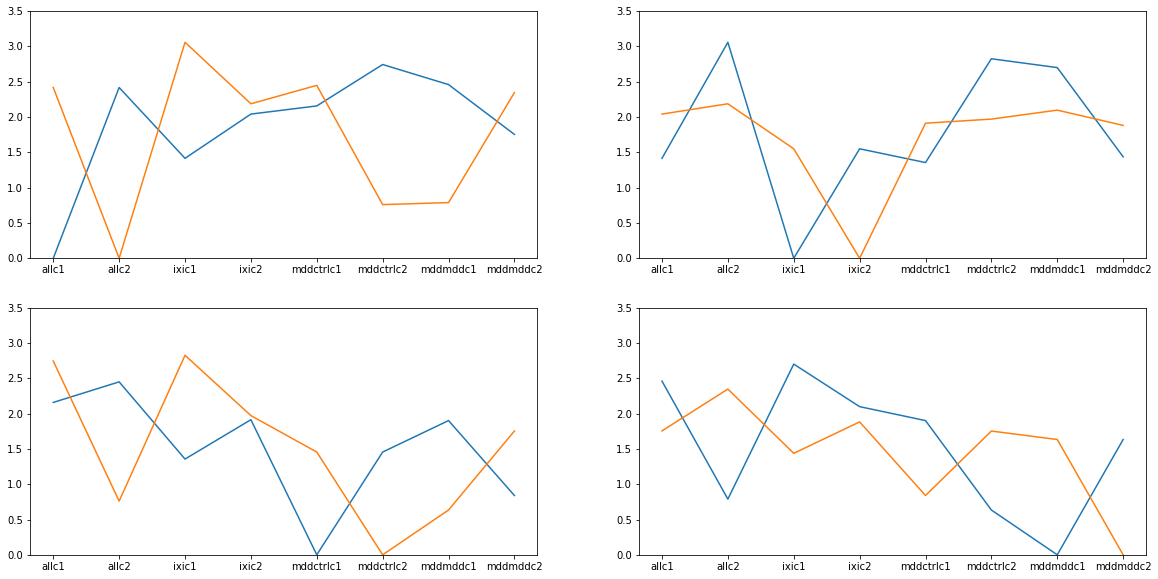

In [289]:
#print('pattern of correlations between the core cluster patterns for the four datasets')
print('pattern of error between the core cluster patterns for the four datasets')
fig=plt.figure(figsize=[20,10])
for z in range(4):
    plt.subplot(2,2,z+1)
    #plt.plot(np.corrcoef(allvecs)[(z*2),:])
    #plt.plot(np.corrcoef(allvecs)[(z*2)+1,:])
    plt.plot(allmse[(z*2),:])
    plt.plot(allmse[(z*2)+1,:])
    plt.xticks(np.arange(8),['allc1','allc2','ixic1','ixic2','mddctrlc1','mddctrlc2','mddmddc1','mddmddc2'])
    plt.ylim(0,3.5)
plt.show()

pattern of correlations between the core cluster patterns for the four datasets


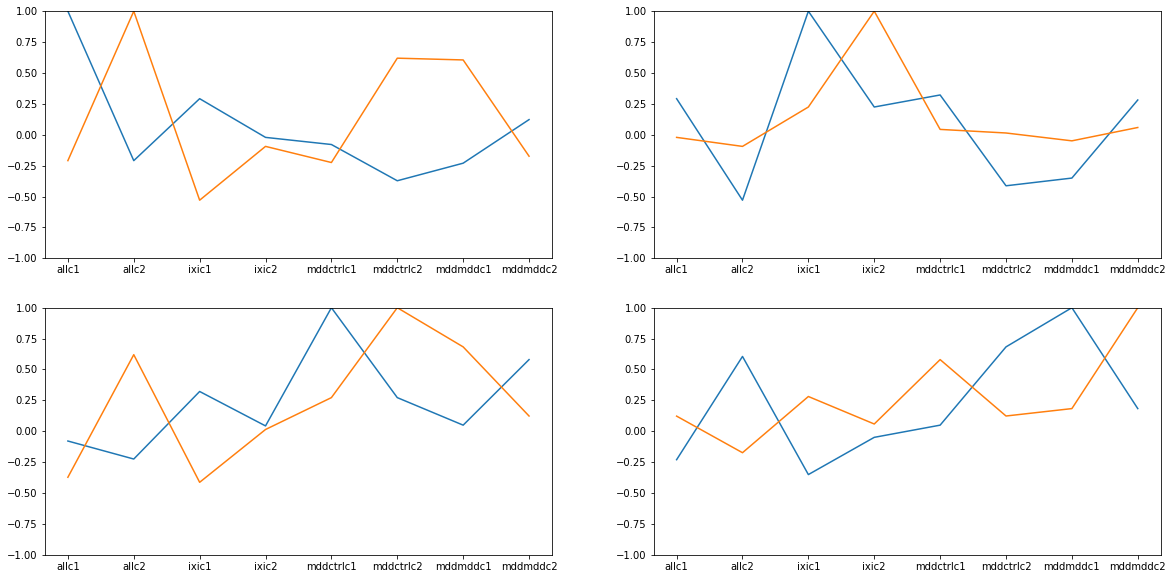

In [290]:
print('pattern of correlations between the core cluster patterns for the four datasets')
fig=plt.figure(figsize=[20,10])
for z in range(4):
    plt.subplot(2,2,z+1)
    plt.plot(np.corrcoef(allvecs)[(z*2),:])
    plt.plot(np.corrcoef(allvecs)[(z*2)+1,:])
    plt.xticks(np.arange(8),['allc1','allc2','ixic1','ixic2','mddctrlc1','mddctrlc2','mddmddc1','mddmddc2'])
    plt.ylim(-1,1)
plt.show()

allc1 and ixic1
0.2919399740448574


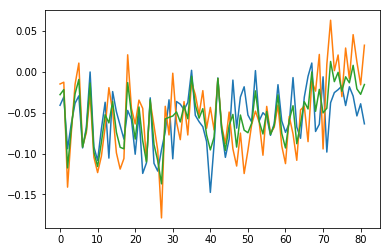

26 ['L_superiorfrontal_thickavg'] -0.12140020555895126 -0.09615663046064489
23 ['L_precuneus_thickavg'] -0.11137410715555202 -0.10904130912347493
10 ['L_lateralorbitofrontal_thickavg'] -0.10841472776156845 -0.12323370726182648
27 ['L_superiorparietal_thickavg'] -0.09532882850446847 -0.178614837451458
2 ['L_caudalmiddlefrontal_thickavg'] -0.09401668145160505 -0.14101690883271775
6 ['L_inferiorparietal_thickavg'] -0.09309302437122449 -0.09140876827177163
9 ['L_lateraloccipital_thickavg'] -0.09173966527654612 -0.10427391971496164
17 ['L_parsorbitalis_thickavg'] -0.08228750265250473 -0.10607246894954178

allc2 and ixic1
-0.5297437634829831


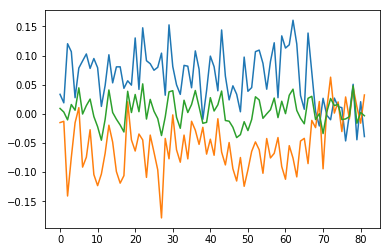

59 ['R_rostralmiddlefrontal_thickavg'] 0.13379539529074097 -0.09054948229750912
2 ['L_caudalmiddlefrontal_thickavg'] 0.12030150711942254 -0.14101690883271775
63 ['R_supramarginal_thickavg'] 0.11993601275338243 -0.10822973949343945
60 ['R_superiorfrontal_thickavg'] 0.11288430786970317 -0.11226284284640159
27 ['L_superiorparietal_thickavg'] 0.10415054992621674 -0.178614837451458


In [340]:
# allc2, mddctrlc2 and mddmddc1 -- anticorrelated with ixic1
# ixic1 and allc1m mddctrlc1 and mddmddc2
print('allc1 and ixic1')
spit_out_vector_overlap(allvecs[0], allvecs[2],20)
print()
print('allc2 and ixic1')
spit_out_vector_overlap(allvecs[1], allvecs[2],20)

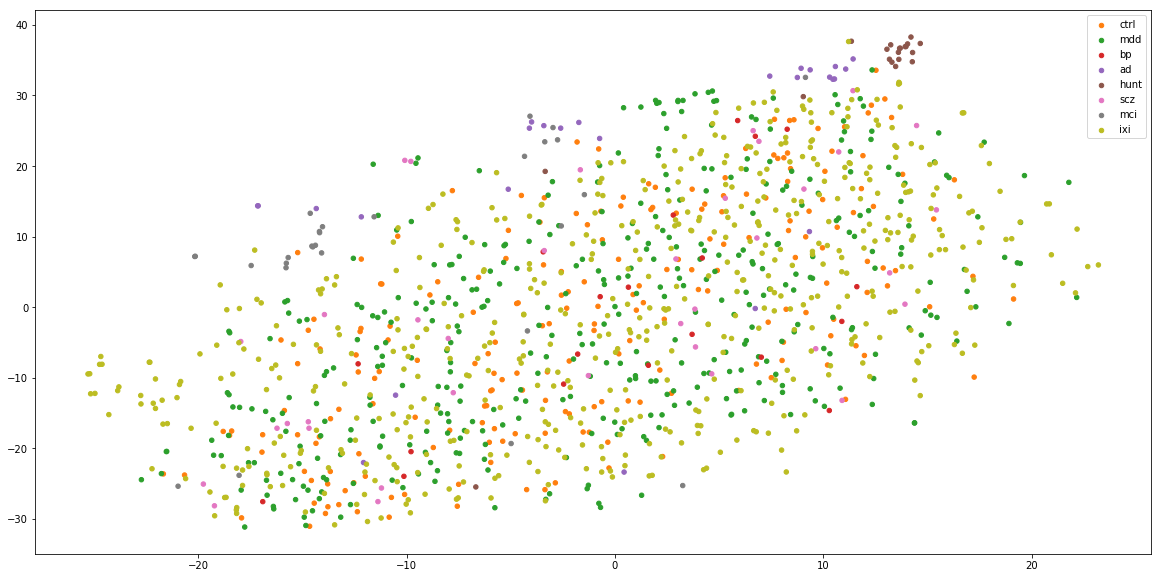

In [293]:
# try plotting all data on the same plot using TSNE
MEGADATA = np.append(all_Tc,ixi_Tc,axis=0)
samplex=np.concatenate([sampleidx,np.ones(544)*8])
mega_tsne=TSNE(n_components=2, perplexity=30, early_exaggeration=1000, learning_rate=2, n_iter=3000).fit_transform(MEGADATA)
fig=plt.figure(figsize=[20,10]); ax=plt.subplot(1,1,1)
colorscatter(mega_tsne, samplex, np.ones(1284)*4, ax, 0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci', 'ixi'])
plt.show()

In [309]:
labelrecode_all = np.zeros(shape=[740,2])
labelrecode_ixi = np.zeros(shape=[554,2])
for mf in range(4):
    for cclus in range(2):
        mfo = np.where(assignedwhere_all[mf,:]==cclus+1)[0]
        acc = np.where(all_labelsmain2[:,0,2,mf]==mfo)[0]
        labelrecode_all[acc,cclus]+=1
        mfo = np.where(assignedwhere_ixi[mf,:]==cclus+1)[0]
        acc = np.where(ixi_labelsmain2[:,0,2,mf]==mfo)[0]
        labelrecode_ixi[acc,cclus]+=1


# allc2, mddctrlc2 and mddmddc1 -- anticorrelated with ixic1
# ixic1 and allc1m mddctrlc1 and mddmddc2

/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/Users/lee_jollans/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


In [316]:
import inspect
source_DF = inspect.getsource(maxvals_beta)
print(source_DF)

def maxvals_beta(c1):
    top10thresh = np.percentile(abs(c1),95)
    top10where=np.where(abs(c1)>top10thresh)[0]
    for i in top10where:
        print(i,Tclabels[i], c1[i])



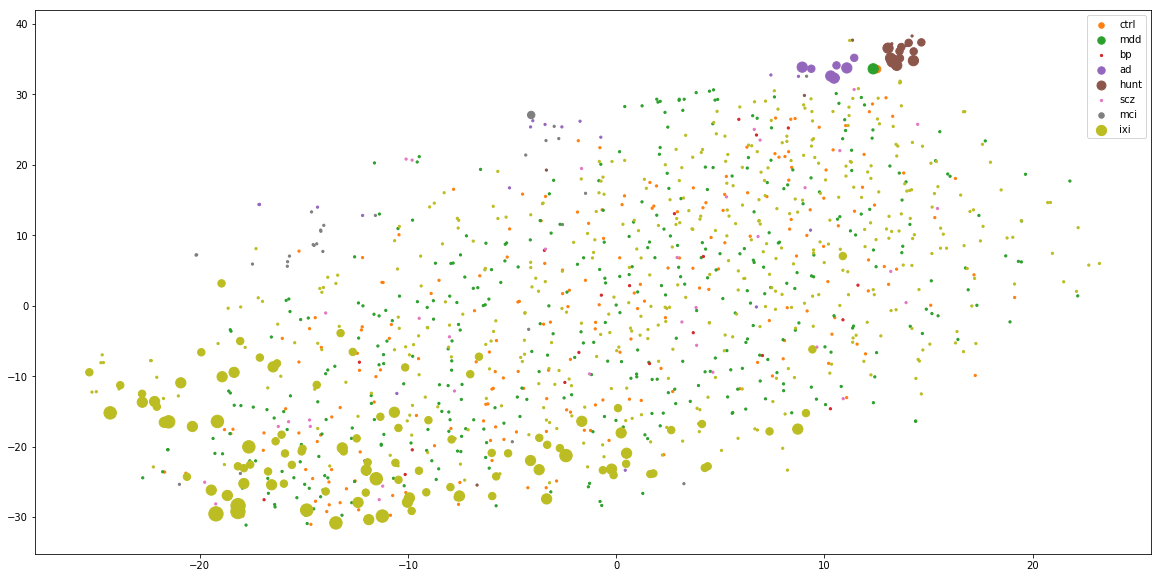

In [297]:
fig=plt.figure(figsize=[20,10]); ax=plt.subplot(1,1,1)
colorscatter(mega_tsne, samplex, np.concatenate([labelrecode_all[:,0]*10+1,labelrecode_ixi[:,0]*10+1]), ax, 0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci', 'ixi'])
plt.show()

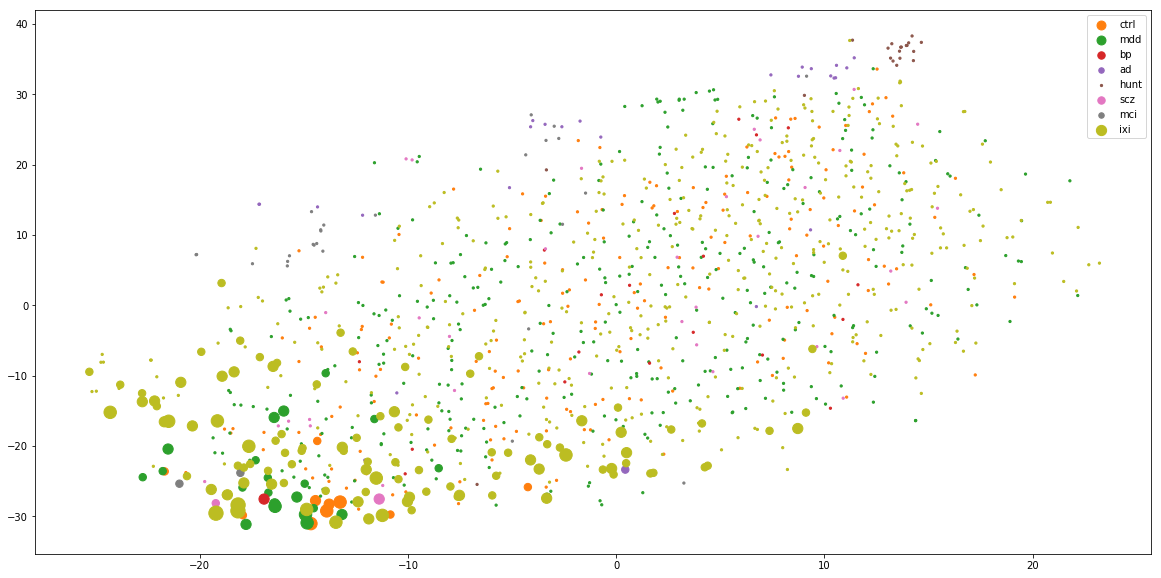

In [298]:
fig=plt.figure(figsize=[20,10]); ax=plt.subplot(1,1,1)
colorscatter(mega_tsne, samplex, np.concatenate([labelrecode_all[:,1]*10+1,labelrecode_ixi[:,0]*10+1]), ax, 0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci', 'ixi'])
plt.show()

0.2921023130080411


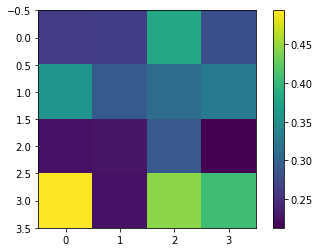

In [263]:
# how similar are the IXI clusters to the ALL clusters?
max_all_ixi_corrs=np.full([4,4],np.nan)
all_ixi_corr = np.full([4,5,4,4],np.nan)
for mf1 in range(4):
    for mf2 in range(4):
        for clus_all in range(4):
            for clus_ixi in range(5):
                crit_all = all_betas[1:,clus_all,mf1]
                crit_ixi = ixi_betas[1:,clus_ixi,mf2]
                all_ixi_corr[clus_all,clus_ixi,mf1,mf2] = np.corrcoef(crit_all, crit_ixi)[0,1]
        max_all_ixi_corrs[mf1,mf2]=(np.nanmax(abs(all_ixi_corr[:,:,mf1,mf2])))
print(np.median(max_all_ixi_corrs))
fig=plt.figure(); plt.imshow(max_all_ixi_corrs); plt.colorbar(); plt.show()

0.3029166821479835


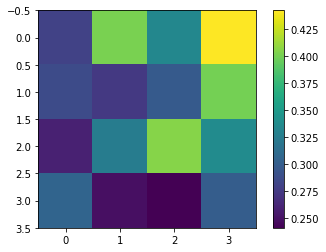

In [264]:
# how similar are the IXI clusters to the MDD clusters?
max_mdd_ixi_corrs=np.full([4,4],np.nan)
mdd_ixi_corr = np.full([3,5,4,4],np.nan)
for mf1 in range(4):
    for mf2 in range(4):
        for clus_mdd in range(3):
            for clus_ixi in range(5):
                crit_mdd = mdd_ctrl_betas[1:,clus_mdd,mf1]
                crit_ixi = ixi_betas[1:,clus_ixi,mf2]
                mdd_ixi_corr[clus_mdd,clus_ixi,mf1,mf2] = np.corrcoef(crit_mdd, crit_ixi)[0,1]
        max_mdd_ixi_corrs[mf1,mf2]=(np.max(abs(mdd_ixi_corr[:,:,mf1,mf2])))
print(np.median(max_mdd_ixi_corrs))
fig=plt.figure(); plt.imshow(max_mdd_ixi_corrs); plt.colorbar(); plt.show()

0.37324583944189815


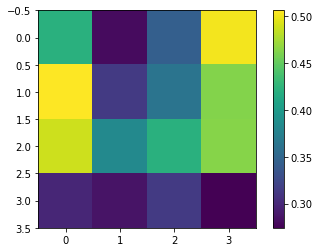

In [265]:
# how similar are the ALL clusters to the MDD clusters?
max_mdd_all_corrs=np.full([4,4],np.nan)
mdd_all_corr = np.full([3,5,4,4],np.nan)
for mf1 in range(4):
    for mf2 in range(4):
        for clus_mdd in range(3):
            for clus_all in range(4):
                crit_mdd = mdd_ctrl_betas[1:,clus_mdd,mf1]
                crit_all = all_betas[1:,clus_all,mf2]
                mdd_all_corr[clus_mdd,clus_all,mf1,mf2] = np.corrcoef(crit_mdd, crit_all)[0,1]
        max_mdd_all_corrs[mf1,mf2]=(np.nanmax(abs(mdd_all_corr[:,:,mf1,mf2])))
print(np.median(max_mdd_all_corrs))
fig=plt.figure(); plt.imshow(max_mdd_all_corrs); plt.colorbar(); plt.show()

[[ 0.52768971  0.18855649 -0.01399523]
 [ 0.14955057  0.59089189 -0.07146992]
 [-0.17484978 -0.08435152  0.79437707]]


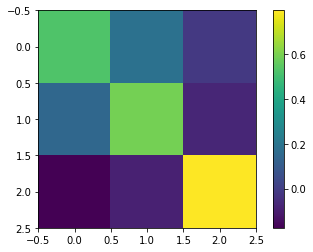

In [218]:
# how similar are the MDD clusters to the MDD clusters?
mdd_mdd_corr = np.full([3,3],np.nan)
for clus_mdd1 in range(3):
    for clus_mdd2 in range(3):
        crit_mdd1 = mdd_mdd_betas[1:,clus_mdd1,0]
        crit_mdd2 = mdd_ctrl_betas[1:,clus_mdd2,0]
        mdd_mdd_corr[clus_mdd1,clus_mdd2] = np.corrcoef(crit_mdd1, crit_mdd2)[0,1]
print(mdd_mdd_corr)   
fig=plt.figure(); plt.imshow(mdd_mdd_corr); plt.colorbar(); plt.show()

In [276]:
# the two solutions that both contained the same MDD patients had th most overlap
# for every solution (every combination of mainfolds) pull the top match
clusmdd=np.full([82,16],np.nan)
clusall=np.full([82,16],np.nan)
ctr=-1
for mf1 in range(4): #mdd
    for mf2 in range(4): #all
        ctr+=1
        crit = mdd_all_corr[:,:,mf1,mf2]
        tophit=np.where(crit==np.nanmax(crit))
        print(tophit, np.nanmax(crit))
        clusmdd[:,ctr]=np.squeeze(mdd_mdd_betas[1:,tophit[0],mf1])
        clusall[:,ctr]=np.squeeze(all_betas[1:,tophit[1],mf2])

(array([1]), array([0])) 0.4214090611244982
(array([1]), array([1])) 0.24327732878822017
(array([2]), array([0])) 0.34394235835224585
(array([1]), array([2])) 0.5014932708886993
(array([1]), array([0])) 0.5058710776857457
(array([2]), array([0])) 0.2727187906271
(array([1]), array([1])) 0.3636617123887352
(array([2]), array([3])) 0.46320976306547085
(array([0]), array([0])) 0.48786238166313856
(array([0]), array([1])) 0.38282996649506107
(array([0]), array([1])) 0.4213208213512088
(array([0]), array([2])) 0.46381497693827717
(array([0]), array([2])) 0.24278101890078382
(array([1]), array([1])) 0.28685017663656087
(array([0]), array([3])) 0.31336915839336504
(array([1]), array([1])) 0.2538323379732205


In [302]:
amdd=abs(np.median((clusmdd),axis=1))
aall=abs(np.median((clusall),axis=1))

spit_out_vector_overlap(amdd,aall)

NameError: name 'clusmdd' is not defined

NameError: name 'clusmdd' is not defined

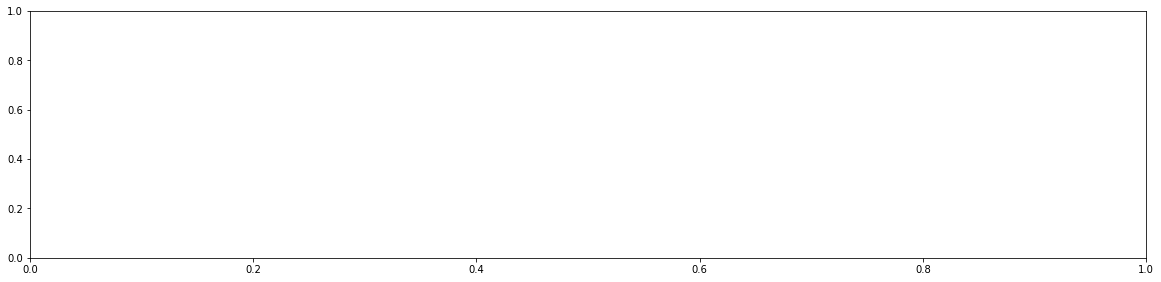

In [303]:
fig=plt.figure(figsize=[20,10])

plt.subplot(2,1,1); plt.plot(clusmdd[a[-5:],:].T);  
plt.title('mdd only'); plt.legend(Tclabels[a[-5:]])

plt.subplot(2,1,2); plt.plot(clusall[a[-5:],:].T);  
plt.title('all'); plt.legend(Tclabels[a[-5:]])

plt.show()

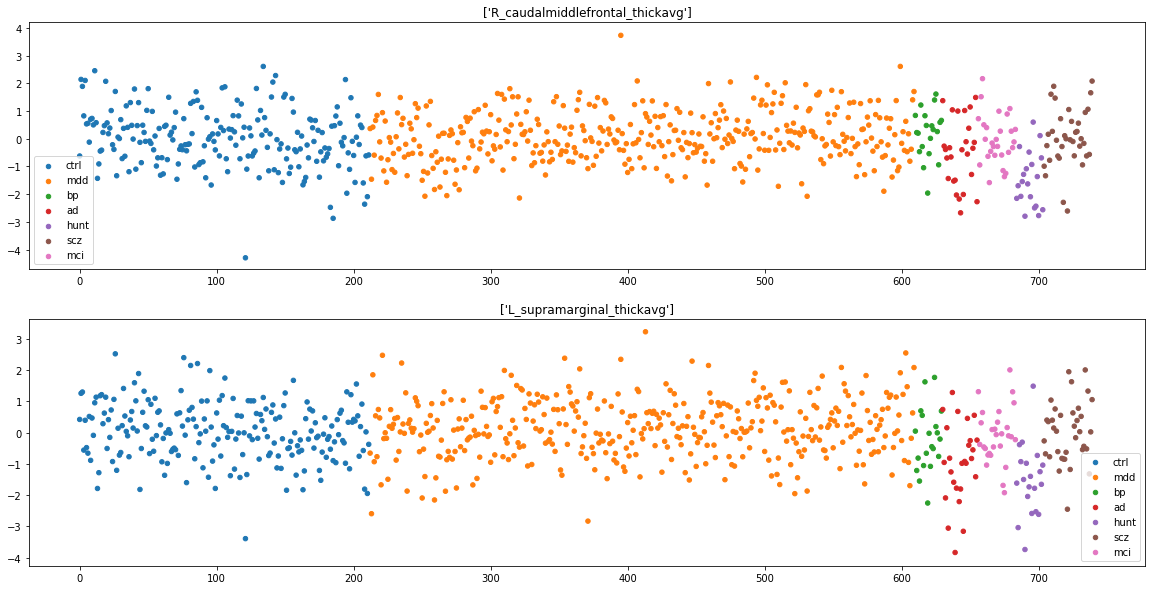

In [326]:
# let's have a closer look at R_caudalmiddlefrontal_thickavg
fig=plt.figure(figsize=[20,10])
ax = plt.subplot(2,1,1)
Xe=np.append(np.expand_dims(np.arange(740),axis=1),np.expand_dims(all_Tc[:,36],axis=1),axis=1)
colorscatter(Xe,sampleidx,np.ones(740)*4,ax)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
plt.title(Tclabels[36])
ax = plt.subplot(2,1,2)
Xe=np.append(np.expand_dims(np.arange(740),axis=1),np.expand_dims(all_Tc[:,29],axis=1),axis=1)
colorscatter(Xe,sampleidx,np.ones(740)*4,ax)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
plt.title(Tclabels[29])
plt.show()

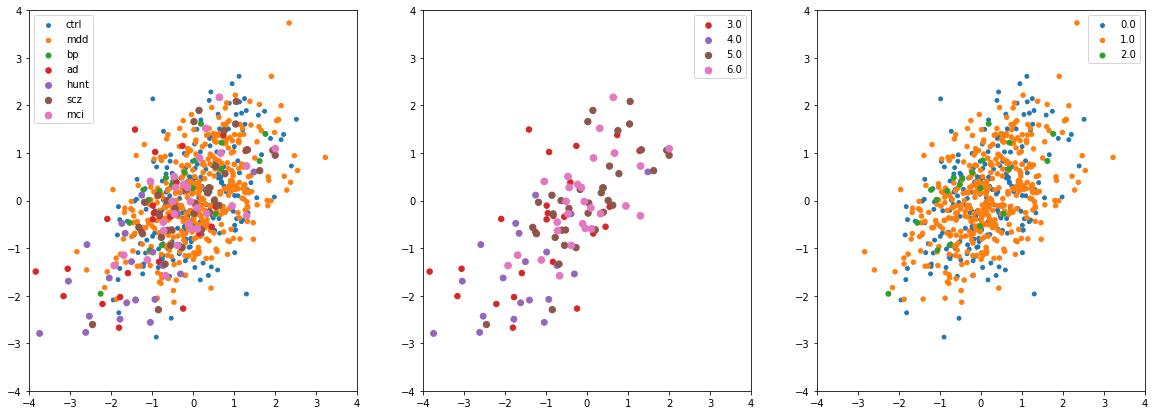

In [382]:
X=all_Tc[:,[29,36]]
sampleidx2=sampleidx-1
hunt_ad = np.concatenate([np.where(sampleidx==4)[0],np.where(sampleidx==5)[0]])
no_mdd_ctrl = np.where(sampleidx>3)[0]
just_mdd_ctrl = np.where(sampleidx<4)[0]

fig=plt.figure(figsize=[20,7])
ax = plt.subplot(1,3,1); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,sampleidx2,sampleidx+2,ax,0);plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
ax = plt.subplot(1,3,2); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[no_mdd_ctrl,:],sampleidx2[no_mdd_ctrl],sampleidx[no_mdd_ctrl]+2,ax,1)
ax = plt.subplot(1,3,3); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[just_mdd_ctrl,:],sampleidx2[just_mdd_ctrl],sampleidx[just_mdd_ctrl]+2,ax,1)
plt.show()

 correlation between ALL cluster 0 and MDD cluster 1: 0.5058710776857457


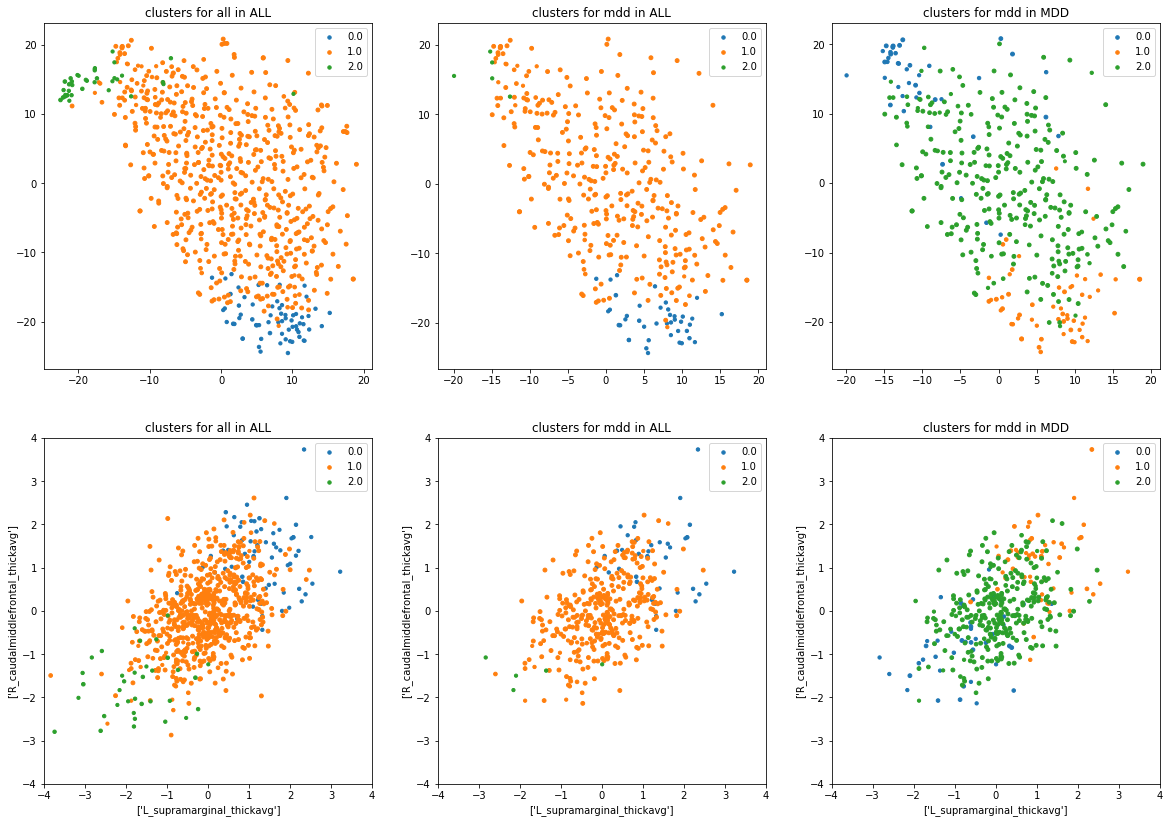

In [417]:
print(' correlation between ALL cluster 0 and MDD cluster 1:', mdd_all_corr[1,0,1,0]) #mdd_all_corr[clus_mdd,clus_all,mf_mdd,mf_all]
findmdd=np.where(dummy_mdd==1)[0]

X=all_tsne#all_Tc[:,[29,36]]

fig=plt.figure(figsize=[20,14])

ax = plt.subplot(2,3,1); plt.title('clusters for all in ALL'); 
colorscatter(X,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,1)

ax = plt.subplot(2,3,2); plt.title('clusters for mdd in ALL'); 
colorscatter(X[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)

ax = plt.subplot(2,3,3); plt.title('clusters for mdd in MDD'); 
colorscatter(X[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)

X=all_Tc[:,[29,36]]

ax = plt.subplot(2,3,4); plt.title('clusters for all in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[29]); plt.ylabel(Tclabels[36]);

ax = plt.subplot(2,3,5); plt.title('clusters for mdd in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[29]); plt.ylabel(Tclabels[36]);

ax = plt.subplot(2,3,6); plt.title('clusters for mdd in MDD'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)
plt.xlabel(Tclabels[29]); plt.ylabel(Tclabels[36]);

plt.show()

[[ 17  41   1   0   1   4   2]
 [189 352  19  17   3  31  26]
 [  6   5   0   9  16   1   0]]


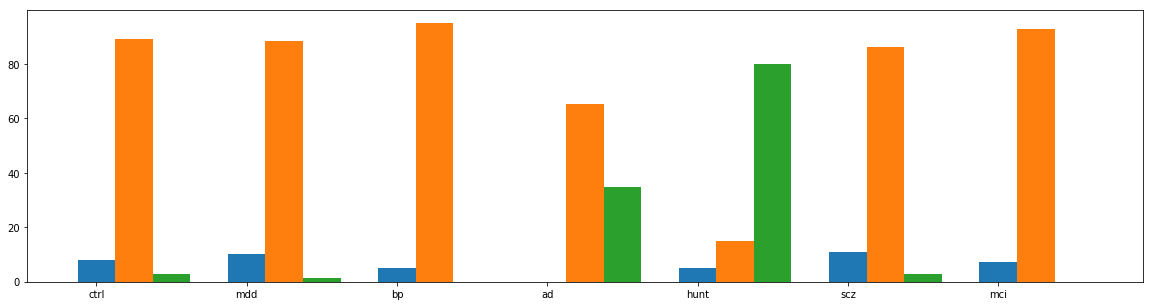

In [411]:
# what portion of controls falls into this cluster?
conmat = contingency_matrix(all_labelsmain2[:,0,2,0], sampleidx)
print(conmat) #['ctrl','mdd','bp','ad','hunt','scz','mci']
z=conmat*100/sum(conmat);

fig=plt.figure(figsize=[20,5])
ax=plt.subplot(1,1,1)
for m in range(3):
    ax.bar(np.arange(7) + 0.25*m, z[m], width = 0.25)
    plt.xticks(np.arange(7),['ctrl','mdd','bp','ad','hunt','scz','mci'])

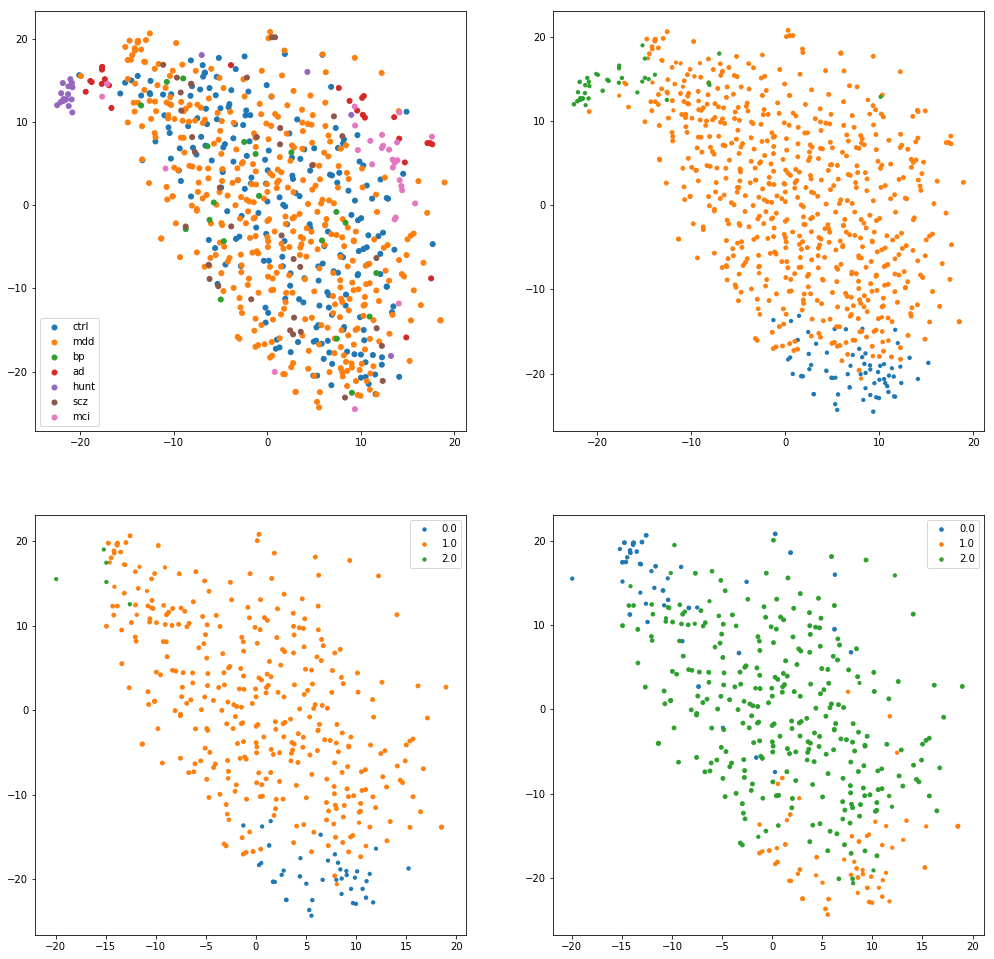

In [429]:
# just for bigger figures to stick into a powerpint

fig = plt.figure(figsize=[17,17])
ax = plt.subplot(2,2,1)
colorscatter(all_tsne,sampleidx-1,np.ones(740)*5, ax,0)
plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
ax = plt.subplot(2,2,2); 
colorscatter(all_tsne,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,0)

ax = plt.subplot(2,2,3); 
colorscatter(all_tsne[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)

ax = plt.subplot(2,2,4); 
colorscatter(all_tsne[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)

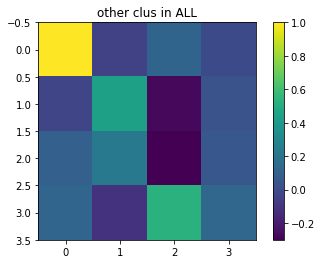

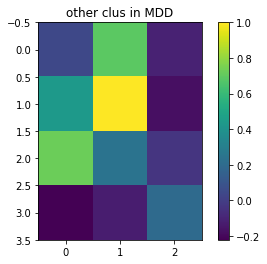

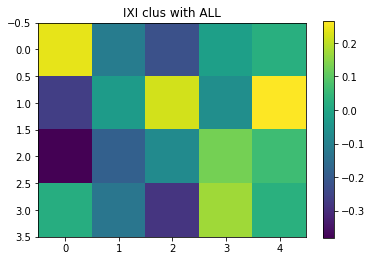

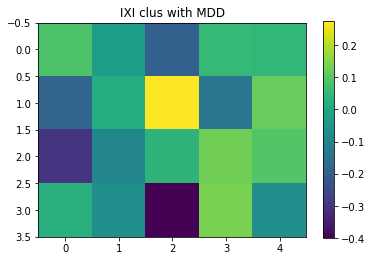

In [476]:
# use those two clusters as index to compare to the other mainfolds and to ixi
mddcrit=mdd_ctrl_betas[1:,1,1]
allcrit=all_betas[1:,0,0]

all_self_clus_corrs = np.full([4,4],np.nan)
mdd_self_clus_corrs = np.full([4,3],np.nan)

for mf in range(4):
    # all
    for clus in range(4):
        all_self_clus_corrs[mf,clus]=np.corrcoef(allcrit,all_betas[1:,clus,mf])[0,1]
    # mdd
    for clus in range(3):
        mdd_self_clus_corrs[mf,clus]=np.corrcoef(mddcrit,mdd_ctrl_betas[1:,clus,mf])[0,1]
# ixi with all
all_ixi_clus_corrs = all_ixi_corr[0,:,0,:].T 
# ixi with mdd
mdd_ixi_clus_corrs = mdd_ixi_corr[1,:,1,:].T

plt.imshow(all_self_clus_corrs); plt.colorbar(); plt.title('other clus in ALL'); plt.show()
plt.imshow(mdd_self_clus_corrs); plt.colorbar(); plt.title('other clus in MDD'); plt.show()
plt.imshow(all_ixi_clus_corrs); plt.colorbar(); plt.title('IXI clus with ALL'); plt.show()
plt.imshow(mdd_ixi_clus_corrs); plt.colorbar(); plt.title('IXI clus with MDD'); plt.show()

0.5058710776857457


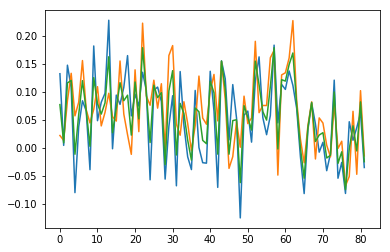

[['R_lateraloccipital_thickavg']
 ['L_middletemporal_thickavg']
 ['R_superiortemporal_thickavg']
 ['R_precuneus_thickavg']
 ['L_precentral_thickavg']]
[array([43, 13, 62, 57, 22])]
[0.15502119 0.1627847  0.16950459 0.17887509 0.17891234]


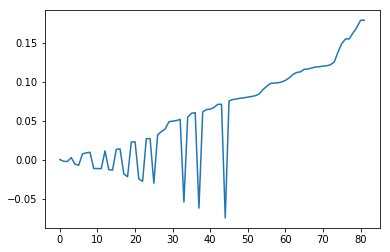

In [477]:
spit_out_vector_overlap(mddcrit,allcrit)

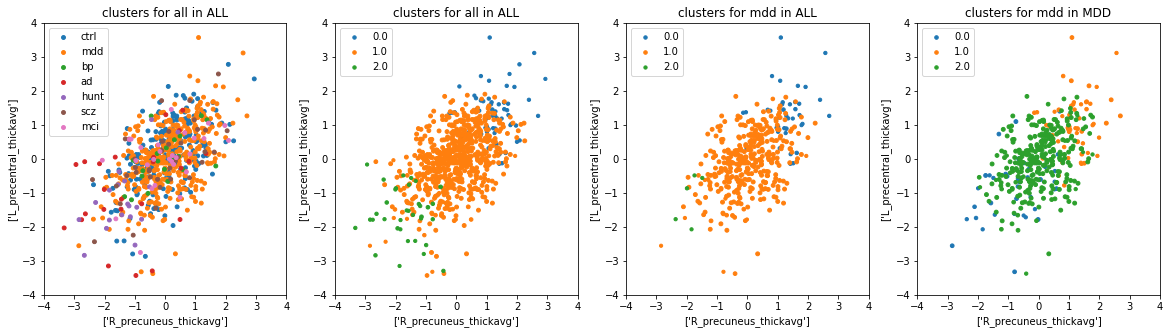

In [501]:
# top weights for the two clusters

X=all_Tc[:,[57,22]]

fig=plt.figure(figsize=[20,5])

ax = plt.subplot(1,4,1); plt.title('clusters for all in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,sampleidx-1,np.ones(740)*3,ax,0); plt.legend(['ctrl','mdd','bp','ad','hunt','scz','mci'])
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

ax = plt.subplot(1,4,2); plt.title('clusters for all in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X,all_labelsmain2[:,0,2,0],all_probamain2[:,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

ax = plt.subplot(1,4,3); plt.title('clusters for mdd in ALL'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],all_labelsmain2[findmdd,0,2,0],all_probamain2[findmdd,0,2,0]*2+1,ax,1)
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

ax = plt.subplot(1,4,4); plt.title('clusters for mdd in MDD'); plt.xlim(-4,4); plt.ylim(-4,4)
colorscatter(X[findmdd,:],mdd_ctrl_labelsmain2[:,0,1,1],mdd_ctrl_probamain2[:,0,1,1]*2+1,ax,1)
plt.xlabel(Tclabels[57]); plt.ylabel(Tclabels[22]);

plt.show()

##ixi same axes
#X=ixi_Tc[:,[57,22]]
#fig=plt.figure(figsize=[20,7])
#for mf in range(4):
#    labels = ixi_labelsmain2[:,0,3,mf]
#    probas = ixi_probamain2[:,0,3,mf]+1
#    ax = plt.subplot(1,4,mf+1)
#    colorscatter(X,labels,probas, ax,1)
#plt.show()


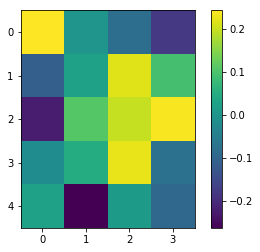

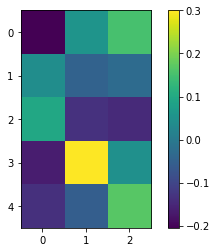

In [457]:
# the most similar solutions wiht ixi were at mf [0,0] for ALL and mf [3,3] for MDD
plt.imshow(all_ixi_corr[:,:,0,0].T ); plt.colorbar(); plt.show()
plt.imshow(mdd_ixi_corr[:,:,3,3].T ); plt.colorbar(); plt.show()

0.24218097778662373


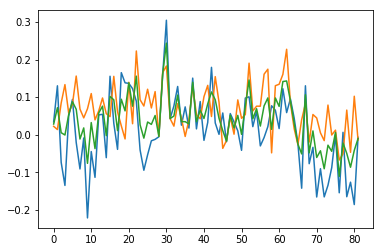

[['R_superiortemporal_thickavg']
 ['R_parstriangularis_thickavg']
 ['L_precentral_thickavg']
 ['L_supramarginal_thickavg']
 ['L_frontalpole_thickavg']]
[array([62, 52, 22, 29, 30])]
[0.14302312 0.145548   0.15575154 0.16086369 0.24356892]


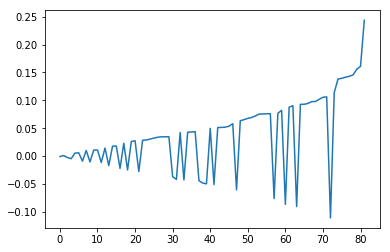

In [478]:
spit_out_vector_overlap(ixi_betas[1:,0,0],all_betas[1:,0,0])

0.23748727221868754


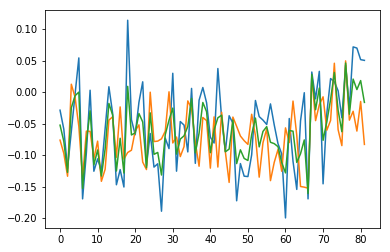

[['L_parsorbitalis_thickavg']
 ['L_superiorparietal_thickavg']
 ['L_lingual_thickavg']
 ['L_inferiorparietal_thickavg']
 ['R_transversetemporal_thickavg']]
[array([17, 27, 11,  6, 66])]
[-0.12849367 -0.13166318 -0.13335983 -0.1530834  -0.16103406]


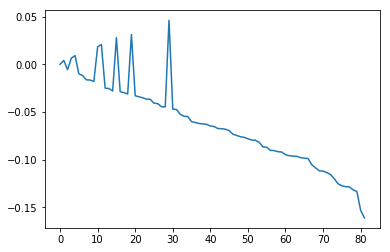

In [479]:
spit_out_vector_overlap(ixi_betas[1:,2,0],all_betas[1:,3,0])

0.21661234719234512


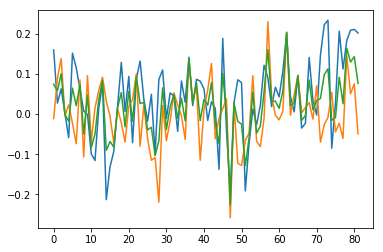

[['Rput']
 ['R_precuneus_thickavg']
 ['Rhippo']
 ['R_superiortemporal_thickavg']
 ['R_middletemporal_thickavg']]
[array([80, 57, 78, 62, 47])]
[ 0.14267261  0.15997467  0.16363958  0.20263132 -0.22638917]


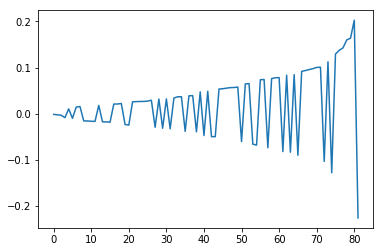

In [480]:
spit_out_vector_overlap(ixi_betas[1:,1,0],all_betas[1:,2,0])

0.22621841297077588


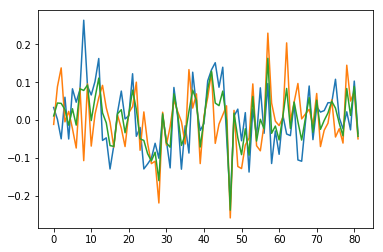

[['L_medialorbitofrontal_thickavg']
 ['R_isthmuscingulate_thickavg']
 ['L_superiortemporal_thickavg']
 ['R_precuneus_thickavg']
 ['R_middletemporal_thickavg']]
[array([12, 42, 28, 57, 47])]
[ 0.11077312  0.12932099 -0.15991611  0.16315006 -0.23789934]


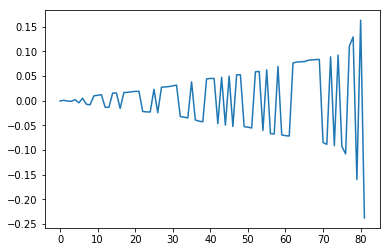

In [481]:
spit_out_vector_overlap(ixi_betas[1:,3,0],all_betas[1:,2,0])

0.30023389828642766


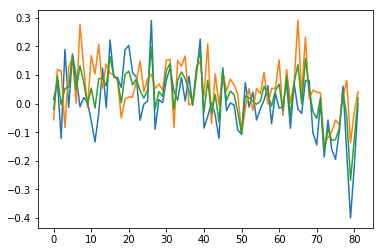

[['Lpal']
 ['L_fusiform_thickavg']
 ['R_fusiform_thickavg']
 ['L_superiorfrontal_thickavg']
 ['Rpal']]
[array([72,  5, 39, 26, 79])]
[-0.16514712  0.1666835   0.18658466  0.19631369 -0.2685176 ]


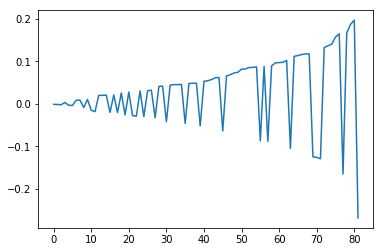

In [482]:
spit_out_vector_overlap(ixi_betas[1:,3,3],mdd_ctrl_betas[1:,1,3])

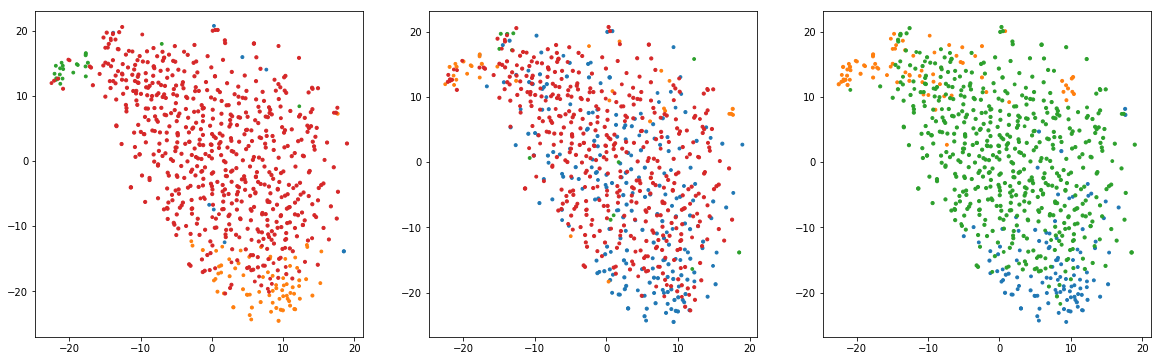

In [499]:
fig = plt.figure(figsize=[20,6])
for s in range(3):

    if s<2:
        labels = all_labelsmain2[:,s,2,1]
        probas = all_probamain2[:,s,2,1]+1
    else:
        labels = all_labelsmain2[:,s,1,1]
        probas = all_probamain2[:,s,1,1]+1
    
    ax = plt.subplot(1,3,s+1)
    colorscatter(all_tsne,labels,probas, ax,0)
    
plt.show()

In [498]:
np.unique(all_labelsmain2[:,0,4,0])

array([0., 1., 2., 3., 4., 5.])

In [508]:
import csv
with open('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/clusmdd.csv',mode='w') as file:
    filewriter = csv.writer(file, delimiter=',')
    filewriter.writerows(clusmdd)
file.close()
with open('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/clusall.csv',mode='w') as file:
    filewriter = csv.writer(file, delimiter=',')
    filewriter.writerows(clusall)
file.close()
with open('/Users/lee_jollans/Projects/clustering_pilot/clusteringpaper/Tclabels.csv',mode='w+',newline='') as file:
    filewriter = csv.writer(file, delimiter=',')
    filewriter.writerows(Tclabels)
file.close()

0.2742700445079815


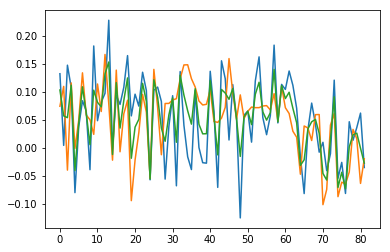

[['L_precentral_thickavg']
 ['L_paracentral_thickavg']
 ['R_pericalcarine_thickavg']
 ['R_inferiorparietal_thickavg']
 ['L_rostralmiddlefrontal_thickavg']
 ['L_parstriangularis_thickavg']
 ['L_transversetemporal_thickavg']
 ['L_medialorbitofrontal_thickavg']
 ['R_precuneus_thickavg']
 ['L_middletemporal_thickavg']]
[array([22, 15, 53, 40, 25, 18, 32, 12, 57, 13])]
[0.11544371 0.11667518 0.11730504 0.12046672 0.12170584 0.12504437
 0.12984777 0.13225905 0.14028133 0.15342398]


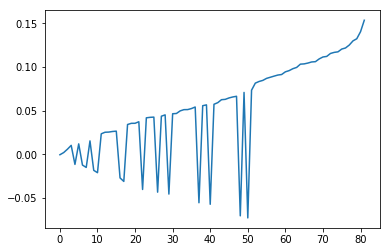

In [514]:
spit_out_vector_overlap(mdd_ctrl_betas[1:,1,1],ixi_betas[1:,2,1])

0.22139608548668407


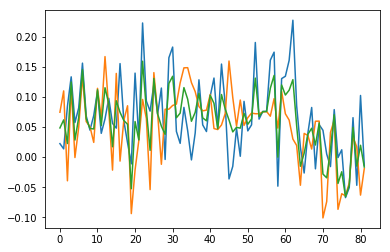

[['R_rostralmiddlefrontal_thickavg']
 ['L_supramarginal_thickavg']
 ['L_cuneus_thickavg']
 ['R_superiortemporal_thickavg']
 ['L_rostralmiddlefrontal_thickavg']
 ['R_parstriangularis_thickavg']
 ['L_frontalpole_thickavg']
 ['R_precuneus_thickavg']
 ['L_inferiorparietal_thickavg']
 ['L_precentral_thickavg']]
[array([59, 29,  3, 62, 25, 52, 30, 57,  6, 22])]
[0.11986522 0.12229773 0.12469516 0.1286052  0.13063025 0.13115831
 0.13422446 0.13565525 0.14505919 0.15919715]


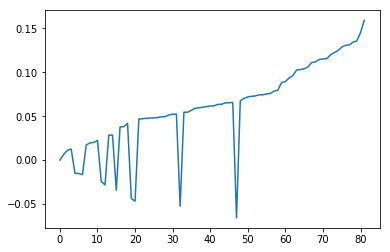

In [515]:
spit_out_vector_overlap(all_betas[1:,0,0],ixi_betas[1:,2,1])

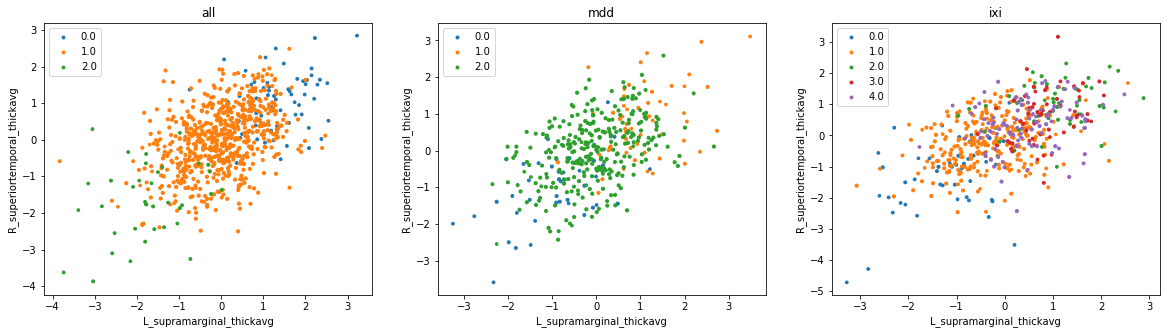

In [525]:
# plot all, mdd, and ixi on a l supramarginal, R suerior temporal space
all_labels_idx = all_labelsmain2[:,0,2,0] #f, set, k ,mainfold
mdd_labels_idx = mdd_ctrl_labelsmain2[:,0,1,1]
ixi_labels_idx = ixi_labelsmain2[:,0,3,1]
all_proba_idx = all_probamain2[:,0,2,0] #f, set, k ,mainfold
mdd_proba_idx = mdd_ctrl_probamain2[:,0,1,1]
ixi_proba_idx = ixi_probamain2[:,0,3,1]


fig=plt.figure(figsize=[20,5])
ax=plt.subplot(1,3,1);
colorscatter(all_Tc[:,[29,62]],all_labels_idx,all_proba_idx+1,ax,1); plt.title('all')
plt.xlabel(Tclabels[29][0]); plt.ylabel(Tclabels[62][0]);
ax=plt.subplot(1,3,2);
colorscatter(mdd_ctrl_Tc[:,[29,62]],mdd_labels_idx,mdd_proba_idx+1,ax,1); plt.title('mdd')
plt.xlabel(Tclabels[29][0]); plt.ylabel(Tclabels[62][0]);
ax=plt.subplot(1,3,3);
colorscatter(ixi_Tc[:,[29,62]],ixi_labels_idx,ixi_proba_idx+1,ax,1); plt.title('ixi')
plt.xlabel(Tclabels[29][0]); plt.ylabel(Tclabels[62][0]);
plt.show()

In [522]:
Tclabels[62]

array(['R_superiortemporal_thickavg'], dtype='<U35')